# Gaussian-Mixture Diffusion Representations  
### Bachelor Thesis – DTU Compute (2025)  
**Author:** Muhammad Hussain Altakmaji (s225785)


## 1&nbsp;&nbsp;Introduction  

Diffusion models learn data distributions by **adding** noise and then **removing** it.  
In continuous time the *forward* process is the stochastic differential equation

$$
\mathrm d\mathbf x_t
\;=\; f(\mathbf x_t,t)\,\mathrm dt \;+\; g(t)\,\mathrm d\mathbf w_t ,
$$

where $\mathbf w_t$ is a Wiener process.  
The objective is to learn the **score**

$$
\nabla_{\mathbf x}\!\log p_t(\mathbf x)
\;=\;
\nabla_{\mathbf x}\!\log \bigl(p(\mathbf x\mid t)\bigr),
$$

so that new samples can be generated by integrating the *reverse-time* SDE.


## 2&nbsp;&nbsp;Background  

### 2.1 Variational Auto-Encoder (VAE)  

Encoder $q_\phi(z\mid x)$ and decoder $p_\theta(x\mid z)$ maximise the ELBO

$$
\mathcal L_{\text{ELBO}}
=
\mathbb E_{q_\phi}\bigl[\log p_\theta(x\mid z)\bigr]
-\operatorname{KL}\!\bigl(q_\phi(z\mid x)\;\|\;p(z)\bigr).
$$

---

### 2.2 Gaussian-Mixture VAE (GMVAE)

The standard Gaussian prior is replaced with a $K$-component mixture

$$
p(z) \;=\; \sum_{k=1}^{K} \pi_k \;
\mathcal N\!\bigl(z \mid \mu_k,\Sigma_k\bigr),
$$

so the KL-term becomes

$$
\operatorname{KL}\!\bigl(q_\phi(z\mid x)\;\|\;p_{\text{GMM}}(z)\bigr)
=
\mathbb E_{q_\phi}\!\Bigl[
\log q_\phi(z\mid x)
-
\log\!\sum_{k=1}^{K} \pi_k\,
\mathcal N(z\mid\mu_k,\Sigma_k)
\Bigr].
$$


## 3&nbsp;&nbsp;Score-based Representation Learning  

### 3.1 Joint Diffusion Representation Learning (JDRL)

$$
\mathcal J_{\text{DRL}}
=
\mathbb E_{t,x_0,x_t}
\Bigl[
\lambda(t)\,
\bigl\|s_\theta(x_t,t,E_\phi(x_0))
-\nabla_{x_t}\log p_{0\!\to\!t}(x_t\mid x_0)\bigr\|_2^2
\;+\;
\gamma\,\|E_\phi(x_0)\|_1
\Bigr].
$$

Here $\lambda(t)$ is the variance-preserving weight.

---

### 3.2 Joint *Gaussian-Mixture* Diffusion RL (JGMVDRL)

$$

\mathcal J_{\text{GMVDRL}}
=
\mathbb E_{t,x_0,x_t}
\Bigl[
\mathbb E_{z\sim q_\phi(z\mid x_0)}
\bigl[\lambda(t)\,
\|s_\theta(x_t,t,z)
-\nabla_{x_t}\log p_{0\!\to\!t}\|_2^2\bigr]
+
\operatorname{KL}\!\bigl(q_\phi(z\mid x_0)\;\|\;p_{\text{GMM}}(z)\bigr)
\Bigr]
$$


# Visual Notebook – Inspecting a Trained GM-Diffusion Model  
This notebook **does not train**; it **loads** pre-trained weights (from *`loadparameters/`*) and produces all the figures used in the thesis:

* Latent-space scatter with Gaussian-mixture density  
* 10 × 10 reconstructions for every mixture component  
* Arbitrary latent-grid sampling

The training scripts live in `src/train/` and write weight files such as  
`Egmvdrluniform.pt`, `Dgmvdrluniform.pt`, `Mgmvdrluniform.pt`.


## 1. Setup: Data Loading & Dynamic Model Import

In this cell we:

1. **Load MNIST** and split into 80% training / 20% testing sets.  
2. **Configure paths** to the `src/model/gmvae.py` file and the `src/loadparameters/` directory.  
3. **Dynamically import** the `gmvae` module so that we can access its classes (`EncoderNN`, `DecoderNN`, `MoG`) without installing it as a package.  
4. Define a helper `load_weights` to load each model’s checkpoint onto the correct device.  
5. **Instantiate** and **load pretrained weights** for the encoder, decoder, and Gaussian‐mixture prior.  


In [ ]:
import math, torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np, matplotlib.pyplot as plt, pathlib, sys, importlib.util

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------- DATA ------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
ds        = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_ds, test_ds = random_split(ds, [int(0.8*len(ds)), len(ds) - int(0.8*len(ds))])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# ----------------- PATHS -----------------------------------------------------
ROOT = pathlib.Path().resolve()                 # .../BSc
SRC  = ROOT / "src"                             # underprojekt-mappen

gmvae_path   = SRC / "model" / "gmvae.py"       # src/model/gmvae.py
weights_path = SRC / "loadparameters"           # src/loadparameters/

if not gmvae_path.exists():
    raise FileNotFoundError(f"gmvae.py ikke fundet: {gmvae_path}")

# ----------------- DYNAMISK IMPORT ------------------------------------------
spec  = importlib.util.spec_from_file_location("gmvae", gmvae_path)
gmvae = importlib.util.module_from_spec(spec)
spec.loader.exec_module(gmvae)

EncoderNN, DecoderNN, MoG = gmvae.EncoderNN, gmvae.DecoderNN, gmvae.MoG

# ----------------- HJÆLPER: load_weights ------------------------------------
def load_weights(model: nn.Module, fname: str):
    f = weights_path / fname
    if not f.exists():
        raise FileNotFoundError(f"Vægtfil mangler: {f}")
    model.load_state_dict(torch.load(f, map_location=device))
    return model.to(device).eval()

# ----------------- INSTANTIER & INDLÆS VÆGTE --------------------------------
emodel = load_weights(EncoderNN(latent_dim=2), "Ae.pt")
dmodel = load_weights(DecoderNN(latent_dim=2), "Ad.pt")
mog_model = load_weights(MoG(D=2, K=10),          "Am.pt")

print("✔️  Alle modeller indlæst med vægte fra src/loadparameters/")


MoG by JT.
✔️  Alle modeller indlæst med vægte fra src/loadparameters/


## 5. Reconstruction & Latent Space Visualization

In this cell we define two plotting utilities and then use them to inspect the learned representations:

1. **`plot_reconstructions(encoder, decoder, data_loader, device, num_images)`**  
   - Displays the first `num_images` MNIST test images (top row) alongside their reconstructions (bottom row).  
   - Runs the encoder to obtain latent codes and then the decoder to reconstruct the images.

2. **`plot_latent_space(encoder, mog_model, data_loader, device)`**  
   - Encodes each test image to its mean latent vector (µ) and plots these 2D points, colored by digit label.  
   - Overlays the Gaussian-mixture prior’s component means (× markers) to show how the learned clusters align with digit classes.

Finally, we call both functions on the test set (`test_loader`) to visualize reconstruction quality and the structure of the latent space.


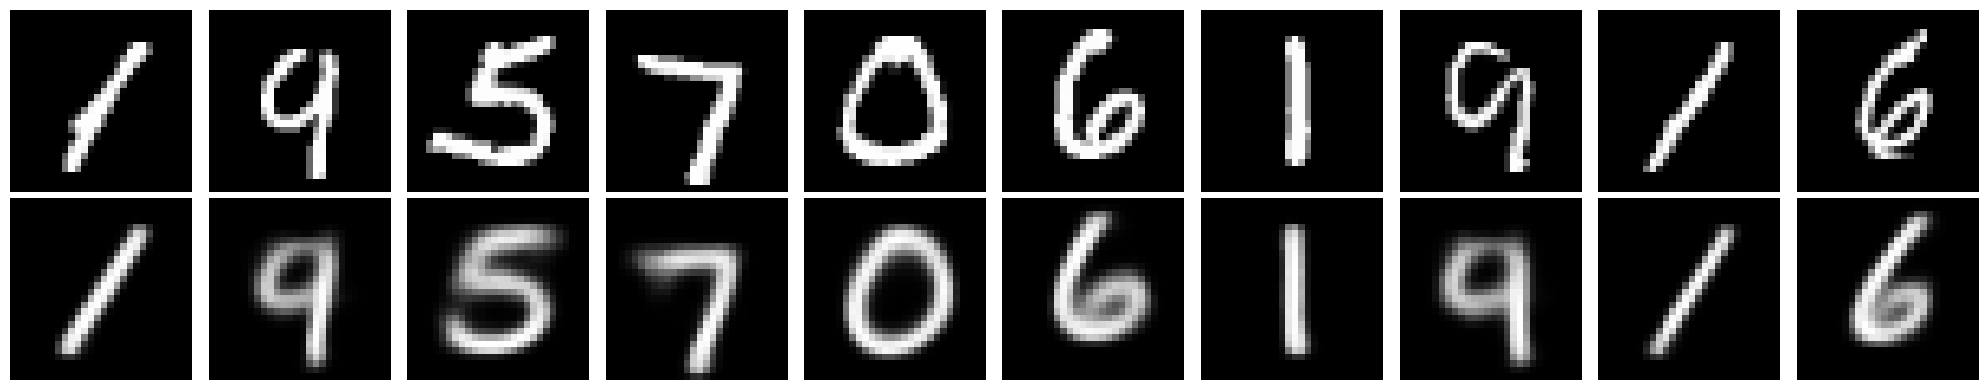

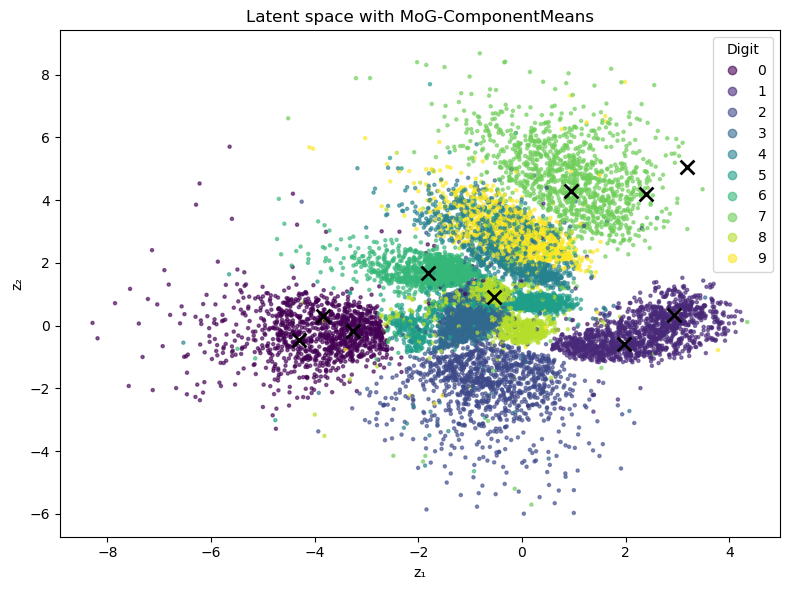

In [65]:
import torch
import matplotlib.pyplot as plt

def plot_reconstructions(encoder, decoder, data_loader, device, num_images=10):
    """
    Viser num_images originale MNIST-billeder (øverst)
    og deres rekonstruktioner (nederst).
    """
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Tag én batch fra dataloaderen
        x, _ = next(iter(data_loader))
        x = x.view(x.size(0), -1).to(device)
        _, _, z = encoder(x)
        x_hat = decoder(z)

        # Flyt tilbage til CPU og form til 28×28-billeder
        x     = x.cpu().view(-1, 1, 28, 28)
        x_hat = x_hat.cpu().view(-1, 1, 28, 28)

        plt.figure(figsize=(num_images * 2, 4))
        for i in range(num_images):
            # Original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(x[i].squeeze(), cmap='gray')
            plt.axis('off')
            # Rekonstruktion
            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(x_hat[i].squeeze(), cmap='gray')
            plt.axis('off')
        #plt.suptitle('1. Row: Original testpoints | 2. Row: Reconstructions')
        plt.tight_layout()
        plt.show()


def plot_latent_space(encoder, mog_model, data_loader, device):
    """
    Scatter-plot af latent space (brug mu som repræsentation),
    farvet efter digit-label,
    med krydser ved hver MoG-komponents gennemsnit.
    """
    encoder.eval()
    mog_model.eval()

    zs = []
    labels = []
    with torch.no_grad():
        for x, y in data_loader:
            x = x.view(x.size(0), -1).to(device)
            mu, _, _ = encoder(x)
            zs.append(mu.cpu())
            labels.append(y)
    zs = torch.cat(zs, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    # Hent Mixture-komponents-gennemsnit og detach før numpy
    comp_means = mog_model.mu.detach().squeeze(0).cpu().numpy()  # shape (K, 2)

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(zs[:, 0], zs[:, 1], c=labels, alpha=0.6, s=5)
    plt.scatter(comp_means[:, 0], comp_means[:, 1],
                marker='x', s=100, c='black', lw=2, label='MoG means')
    plt.legend(*sc.legend_elements(), title="Digit")
    plt.title('Latent space with MoG-ComponentMeans')
    plt.xlabel('z₁')
    plt.ylabel('z₂')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


# ---- Eksempel på brug ----
# Sørg for at have defineret:
#   emodel, dmodel, mog_model, test_loader, device

plot_reconstructions(emodel, dmodel, test_loader, device, num_images=10)
plot_latent_space(emodel, mog_model, test_loader, device)


## 4 Reconstructing the Mittal et al. (2023) Score‐Based Diffusion Model

In this section we describe how we reproduce the key components of Mittal et al.’s “Score‐Based Generative Modeling” (Mittal 23a) framework, then replace their variance‐exploding (VE) SDE, uniform time‐sampling, and fixed drift schedule with:

1. A variance‐preserving (VP) SDE  
2. Beta–distributed time sampling for high‐noise emphasis  
3. A learnable Gaussian mixture prior on the latent \(z\)

---

### 4.1 The Mittal 23a VE SDE and Score‐Matching Objective

They use the variance‐exploding SDE
$$
\mathrm{d}x_t \;=\; g(t)\,\mathrm{d}w_t,
\quad
x_0\sim p_{\rm data},
$$
with
$$
g(t)
=
\sqrt{\frac{\mathrm{d}}{\mathrm{d}t}\,\sigma^2(t)},
\qquad
\sigma(t)
=
\sigma_{\min}
\Bigl(\frac{\sigma_{\max}}{\sigma_{\min}}\Bigr)^t,
$$
so that
\(\sigma^2(t)\) grows from \(\sigma_{\min}^2\) to \(\sigma_{\max}^2\).  The score‐matching loss is
$$
\mathcal{L}_{\mathrm{VE}}(\theta)
=
\mathbb{E}_{t\sim\mathcal{U}[0,1],\,x_0,\,\xi}
\Bigl\|
s_\theta(x_t,t)
\;-\;
\nabla_{x_t}\log\mathcal{N}\bigl(x_t;\,x_0,\;\sigma^2(t)\mathbf{I}\bigr)
\Bigr\|^2_2,
$$
with \(x_t = x_0 + \sigma(t)\,\xi,\;\xi\sim\mathcal{N}(0,\mathbf{I})\).

---

### 4.2 Our VP Reformulation

We switch to the variance‐preserving SDE
$$
\mathrm{d}x_t
=
-\tfrac12\,\beta(t)\,x_t\,\mathrm{d}t
\;+\;\sqrt{\beta(t)}\,\mathrm{d}w_t,
$$
where
$$
\beta(t)
=
\beta_{\min}
\;+\;
t\,(\beta_{\max}-\beta_{\min}),
\qquad
\lambda(t)
=
1
-
\exp\!\Bigl(
-\,\tfrac12\,t^2\,(\beta_{\max}-\beta_{\min})
\;-\;
\beta_{\min}\,t
\Bigr).
$$
Under this SDE,
$$
x_t
\;\sim\;
\mathcal{N}\!\Bigl(
e^{-\frac12\int_0^t\beta(s)\,\mathrm{d}s}\,x_0,\;
\bigl(1 - e^{-\int_0^t\beta(s)\,\mathrm{d}s}\bigr)\,\mathbf{I}
\Bigr),
$$
and our score‐matching loss is
$$
\mathcal{L}_{\mathrm{VP}}(\theta)
=
\mathbb{E}_{t,x_0,\xi}
\Bigl[
\lambda(t)\,
\bigl\|
s_\theta(x_t,t)
\;-\;
\frac{-\xi}{\sqrt{1 - e^{-\int_0^t\beta(s)\,\mathrm{d}s}}}
\bigr\|^2_2
\Bigr].
$$

---

### 4.3 β–Distributed Time Sampling

Rather than \(t\sim\mathcal{U}[0,1]\), we draw
$$
t \;\sim\;
\begin{cases}
\mathrm{Beta}(7,2), & \text{if epoch}\le50,\\
\mathcal{U}[10^{-3},1], & \text{otherwise},
\end{cases}
$$
to emphasize large‐\(t\) (high‐noise) steps before reverting to uniform sampling.

---

### 4.4 Joint GM‐Diffusion RL Objective

Adding a latent encoder \(q_\phi(z\mid x_0)\) and a Gaussian‐mixture prior \(p_{\rm GMM}(z)\), we minimize
$$
\mathcal{J}_{\mathrm{GMVDRL}}
=
\mathbb{E}_{t,x_0,x_t,z}
\Bigl[
\lambda(t)\,
\|\,s_\theta(x_t,t,z)
\;-\;
\nabla_{x_t}\log p_{0\to t}(x_t\mid x_0)\|^2_2
\;+\;
\gamma\,
\mathrm{KL}\bigl(q_\phi(z\mid x_0)\,\|\,p_{\rm GMM}(z)\bigr)
\Bigr],
$$
where \(\gamma\) is annealed from 0 to a final value (e.g.\ \(10^{-6}\)) over the first epochs.

---

By swapping VE for VP, introducing β‐distributed sampling, and adding a GMM on \(z\), this section rebuilds Mittal 23a’s core while enabling representation learning via score‐based diffusion.


J_DRL formulation

In [54]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

full_dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
train_size = 1000
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Uniform 

## 1. Dynamic Import and Model Initialization

This cell automatically locates and imports your core model definitions (`helpers.py`, `unet.py` and `encoder.py`), whether you run it as a standalone script or inside a Jupyter notebook. It then searches for the pre-trained checkpoint files in the `loadparameters/` directory, instantiates the `DenoisingNN` and `EncoderNN` classes, loads their weights onto the chosen device (CPU or GPU), and switches both networks into evaluation mode.


In [55]:
# ---------------------------------------------------------------------------
#   Find / indlæs  helpers.py ,  unet.py ,  encoder.py  +  vægtfiler
#   – fungerer både i .py-skript og i Jupyter-notebook
# ---------------------------------------------------------------------------
import torch, importlib.util, pathlib, sys, types

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------- 1) Projektrod --------------------------------------------------
try:
    ROOT = pathlib.Path(__file__).resolve().parent          # når du kører .py
except NameError:
    ROOT = pathlib.Path().resolve()                         # Jupyter-notebook

# ----------- 2) Find filerne ------------------------------------------------
MODEL_DIR  = next((p for p in [ROOT,
                               ROOT / "model",
                               ROOT / "src" / "model"]
                   if (p / "unet.py").exists()), None)
if MODEL_DIR is None:
    raise FileNotFoundError("Kunne ikke finde unet.py / encoder.py i projektet")

HELPERS_PATH = MODEL_DIR / "helpers.py"
UNET_PATH    = MODEL_DIR / "unet.py"
ENC_PATH     = MODEL_DIR / "encoder.py"

# ----------- 3) Opret 'model'-pakke-stub i sys.modules ---------------------
pkg_name = "model"
if pkg_name not in sys.modules:
    pkg = types.ModuleType(pkg_name)
    pkg.__path__ = [str(MODEL_DIR)]       # gør det til en pakkestub
    sys.modules[pkg_name] = pkg

# ----------- 4) Dynamisk import som  model.helpers  ------------------------
def import_as(fullname: str, py_path: pathlib.Path):
    spec = importlib.util.spec_from_file_location(fullname, py_path)
    mod  = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    sys.modules[fullname] = mod
    return mod

helpers_mod = import_as(f"{pkg_name}.helpers", HELPERS_PATH)
unet_mod    = import_as(f"{pkg_name}.unet",     UNET_PATH)
enc_mod     = import_as(f"{pkg_name}.encoder",  ENC_PATH)

DenoisingNN = unet_mod.DenoisingNN
EncoderNN   = enc_mod.EncoderNN

# ----------- 5) Vægtfiler ---------------------------------------------------
WEIGHT_DIR = next((p for p in [ROOT / "loadparameters",
                               ROOT / "src" / "loadparameters"]
                   if (p / "ScoreDifl1betaVP.pt").exists()), None)
if WEIGHT_DIR is None:
    raise FileNotFoundError("Kunne ikke finde vægtfilerne i projektet")

def load_weights(model: torch.nn.Module, fname: str):
    wfile = WEIGHT_DIR / fname
    if not wfile.exists():
        raise FileNotFoundError(f"Mangler vægtfil: {wfile}")
    model.load_state_dict(torch.load(wfile, map_location=device))
    return model.to(device).eval()

dmodel = load_weights(DenoisingNN(), "ScoreDifl1UniformVP.pt")
emodel = load_weights(EncoderNN(),   "ScoreEncl1UniformVP.pt")

print("✔️  Alt indlæst korrekt!")
print(f"   • helpers   : {HELPERS_PATH}")
print(f"   • unet      : {UNET_PATH}")
print(f"   • encoder   : {ENC_PATH}")
print(f"   • vægte fra : {WEIGHT_DIR}")


✔️  Alt indlæst korrekt!
   • helpers   : /Users/muhammadhussain/Desktop/BSc/src/model/helpers.py
   • unet      : /Users/muhammadhussain/Desktop/BSc/src/model/unet.py
   • encoder   : /Users/muhammadhussain/Desktop/BSc/src/model/encoder.py
   • vægte fra : /Users/muhammadhussain/Desktop/BSc/src/loadparameters


## N. Scatter Plot of Latent Means Colored by True Labels

This cell iterates over the test dataset, passes each example through the trained encoder (`emodel`) to extract the 2-dimensional latent mean vector \(\mu\), and then plots these \((z_1,z_2)\) coordinates as a scatter plot. Each point is colored according to its true MNIST label, allowing you to visually assess how well the encoder has clustered different digit classes in the latent space.


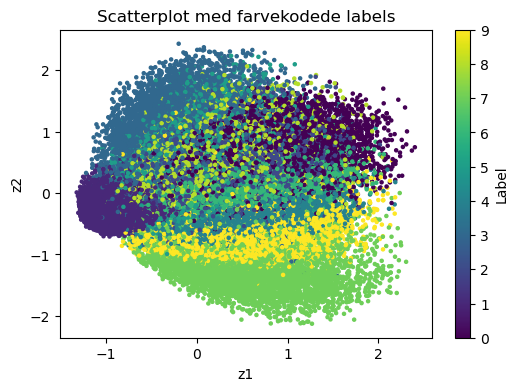

In [56]:
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
#dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
from torch.utils.data import Subset
dataloader = test_loader = DataLoader(
                          test_dataset,
                          batch_size=1,
                          shuffle=False,
                      )



listt = []

for x0, label in dataloader:
    x0 = x0.view(x0.size(0), -1)
    with torch.no_grad():
        output, _ , x = emodel(x0)
        #torch.cat((xt, emodel(x0)), dim=1)
        listt.append((output, label))

coords = [t[0].squeeze() for t in listt]  # Hver er nu en tensor med form [2]
labels = [t[1].item() for t in listt]       # Konverter label til et tal

# Udtræk x- og y-værdier:
xs = [pt[0].item() for pt in coords]
ys = [pt[1].item() for pt in coords]

# Lav scatterplot med farve baseret på labels:
plt.figure(figsize=(6,4))
plt.scatter(xs, ys, c=labels, s=5)
plt.colorbar(label='Label')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Scatterplot med farvekodede labels')
plt.show()

### Conditional Sampling via Reverse SDE

In this cell we:

1. **Define the noise schedules and diffusion steps**  
   - `sigma(t)` and `betat(t)` implement the VE and VP noise schedules.  
   - `forward_process(x0, t)` simulates the **forward** diffusion \(q(x_t \mid x_0)\).  
   - `backward(xt, t, z)` takes one Euler–Maruyama step of the **reverse** SDE, conditioned on the latent code `z`.

2. **Choose a conditioning latent**  
   - We pick a random MNIST example of digit `x`, encode it via `emodel` to get `z = Eφ(x₀)`.  

3. **Simulate sampling**  
   - Start from pure Gaussian noise at \(t=1\).  
   - Run the reverse diffusion from \(t=1 \to 0\) in small steps \(\Delta t\).  
   - Collect all intermediate `xt`.

4. **Visualize results**  
   - Plot the **final** denoised sample (`xt` at \(t\approx0\)).  
   - Plot a row of `n_to_plot` **evenly spaced snapshots** to show the progression of denoising over time.


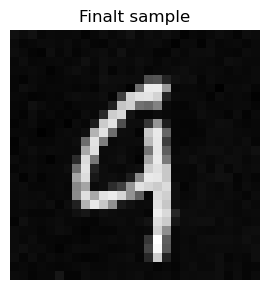

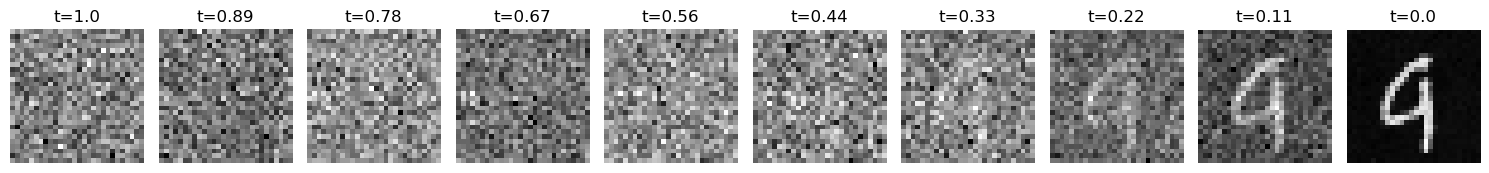

In [57]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)



def sigma(t, smin = 0.01, smax= 50):
    #return t
    return smin * (smax/smin)**t


def betat(t, bmax=20, bmin=0.1):
    return bmin + t * (bmax - bmin)

def backward(xt, t, z, delta=0.1, type = "VP"):
    with torch.no_grad():

        t_time = torch.full((xt.size(0), 1), t, dtype=torch.float32)
        noise = torch.randn_like(xt)
        wiener = noise * np.sqrt(delta)

        z, _, _ = emodel(z)

        if type == "VP":

          xtd = xt + 0.5 * betat(t) * xt * delta \
                + betat(t) * dmodel(xt, t_time, z) * delta \
                + np.sqrt(betat(t)) * wiener

        elif type == "VE":

          smin, smax = 0.01, 50

          torch.tensor(sigma(t)**2 - sigma(0)**2, dtype=torch.float32)

          g = sigma(t) * math.sqrt(2*math.log(smax/smin))
          xtd = (
              xt
              - g**2 * dmodel(xt, t_time, z) * delta
              + g * noise * math.sqrt(delta)
          )



    return xtd



def forward_process(x0, t, bmax=20, bmin=0.1, type = "VP"):

    if type == "VE":

        var = torch.tensor(sigma(t)**2 - sigma(0)**2, dtype=torch.float32)
        noise = torch.randn_like(x0)
        std = torch.sqrt(var)
        xt = x0   +  std  * noise
        logp = -noise / std


    elif type == "VP":
        var = torch.tensor(1 - np.exp(-0.5 * t**2 * (bmax - bmin) - t * bmin),
                      dtype=torch.float32, device=x0.device)
        noise = torch.randn_like(x0)
        std = torch.sqrt(var)
        mu = torch.tensor(np.exp(-0.25 * t**2 * (bmax - bmin) - 0.5 * t * bmin),
                          dtype=torch.float32, device=x0.device) * x0
        xt = mu + std * noise
        logp = -noise / std

    return xt, logp




indices = (dataset.targets == 1).nonzero(as_tuple=True)[0].tolist()
x0, _ = dataset[random.choice(indices)]
x0 = x0.view(1, -1)



x0 = torch.randn_like(x0)

# Start forward process (t=1)
xt, _ = forward_process(x0, 1, type = "VP")


# Definer delta (tidssteg)
delta = 0.001
t_values = np.arange(1, -delta, -delta)

x = 6
z = dataset[random.choice((dataset.targets == x).nonzero(as_tuple=True)[0].tolist())][0]
z = z.view(z.size(0), -1)



# Gem samples under backward process
samples = [xt.clone()]
for t in t_values[1:]:
    xt = backward(xt, t, z, delta=delta, type = "VP")
    samples.append(xt.clone())

# Plot det endelige sample (sidste billede)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
img_to_show = samples[-1].view(28, 28).cpu().numpy()
ax.imshow(img_to_show, cmap='gray')
ax.set_title("Finalt sample")
ax.axis("off")
plt.tight_layout()
plt.show()

# Plot en række billeder jævnt fordelt over processen (fx 10 billeder)
n_to_plot = 10
indices_to_plot = np.linspace(0, len(samples) - 1, n_to_plot, dtype=int)
fig, axes = plt.subplots(1, n_to_plot, figsize=(15, 2))
for i, idx in enumerate(indices_to_plot):
    img = samples[idx]
    img_to_show = img.view(28, 28).cpu().numpy()
    axes[i].imshow(img_to_show, cmap='gray')
    t_val = 1 - idx * delta
    axes[i].set_title(f"t={round(t_val, 2)}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()


### ⑤ Latent‐Conditioned Sampling Grid

This cell generates a 10×10 grid of images by running the reverse SDE for each point in a regular grid over the 2D latent space \(z\in[-1,1]^2\):

1. **Define a grid** of latent vectors \((z_1,z_2)\) equally spaced in \([-1,1]\times[-1,1]\).
2. **For each grid point**:
   - Start from pure Gaussian noise at \(t=1\).
   - Run the VP‐SDE reverse Euler–Maruyama sampler conditioned on that latent \(z\).
   - Collect the final denoised image.
3. **Plot** the resulting 10×10 array, with column and row headers indicating the \((z_1,z_2)\) coordinates.

This visualization shows how varying the latent code steers the generated MNIST-like samples.  


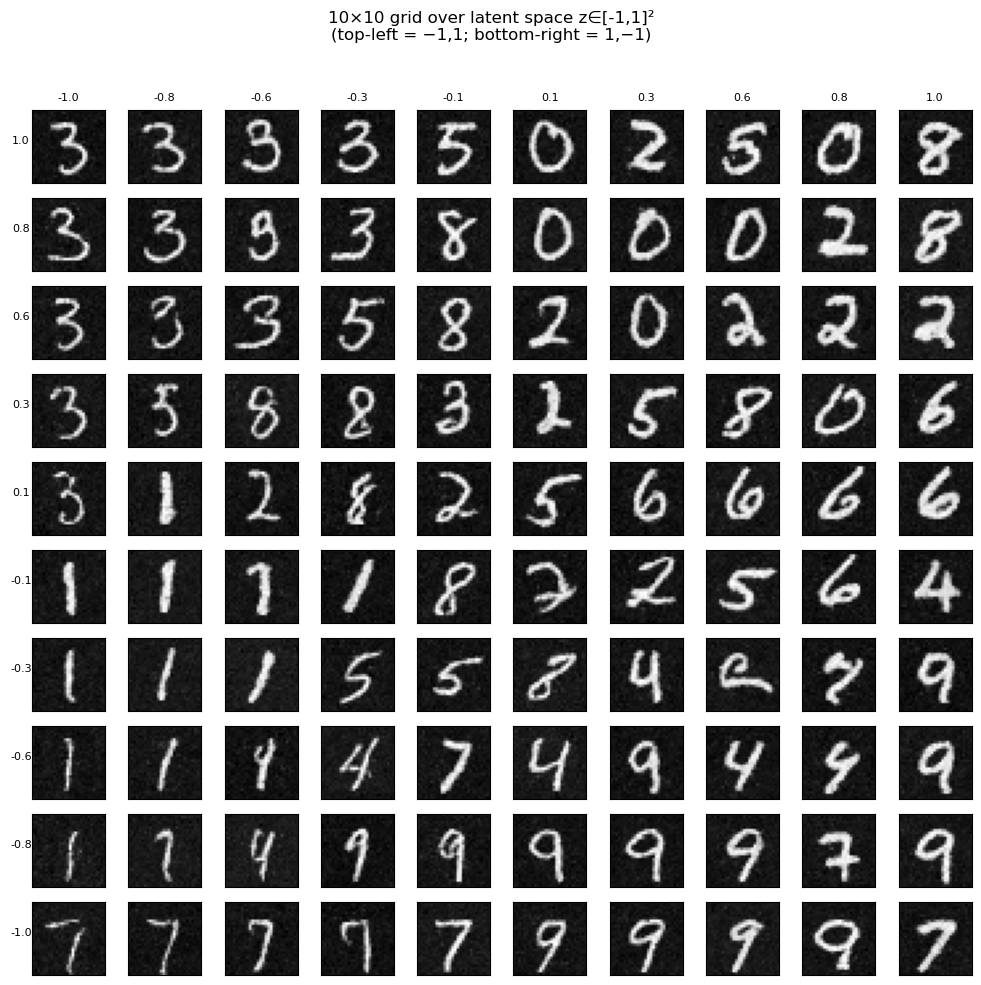

In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def betat(t, bmax=20, bmin=0.1):
    return bmin + t * (bmax - bmin)

def backward(xt, t, z, delta=0.1, type="VP"):
    with torch.no_grad():
        device = xt.device
        t_time = torch.full((xt.size(0), 1), t,
                            dtype=torch.float32, device=device)
        noise  = torch.randn_like(xt)
        wiener = noise * math.sqrt(delta)

        # Fjern denne linje – z er allerede latent_mu fra emodel(x0)
        # z, _, _ = emodel(z)

        if type == "VP":
            beta_t = betat(t)
            xtd = (
                xt
                - 0.5 * beta_t * xt * delta
                + beta_t * dmodel(xt, t_time, z) * delta
                + math.sqrt(beta_t) * wiener
            )

        elif type == "VE":
            smin, smax = 0.01, 50
            sigma_t = sigma(t, smin, smax)
            g       = sigma_t * math.sqrt(2 * math.log(smax/smin))

            xtd = (
                xt
                - g**2 * dmodel(xt, t_time, z) * delta
                + g   * noise * math.sqrt(delta)
            )

        else:
            raise ValueError(f"Unknown SDE type {type!r}")

    return xtd

def betat(t, bmax=20, bmin=0.1):
    return bmin + t * (bmax - bmin)

# 1) Lav et 10×10 grid over latent space [-2,2]×[-2,2]
grid_size = 10
zs = []
xs = np.linspace(-1.0, 1.0, grid_size)      # latent x-koordinater
ys = np.linspace( 1.0, -1.0, grid_size)     # latent y-koordinater (omvendt for plotting)
for yi in ys:
    row = []
    for xi in xs:
        z = torch.tensor([[xi, yi]], dtype=torch.float32, device=device)  # shape (1,2)
        row.append(z)
    zs.append(row)

# 2) Generér én sample per grid-celle via diffusion
n_steps    = 50
delta      = 1.0 / n_steps
t_schedule = np.linspace(1.0, 0.0, n_steps+1)

samples = [[None]*grid_size for _ in range(grid_size)]
with torch.no_grad():
    for i in range(grid_size):
        for j in range(grid_size):
            z = zs[i][j]
            # start fra rent støj
            noise = torch.randn(1, 28*28, device=device)
            xt, _ = forward_process(noise, 1.0)
            # kør backward-process
            for t in t_schedule[1:]:
                xt = backward(xt, t, z, delta)
            samples[i][j] = xt.view(28,28).cpu().numpy()

# 3) Plot 10×10 grid
fig, axs = plt.subplots(grid_size, grid_size, figsize=(10,10),
                        subplot_kw={'xticks':[], 'yticks':[]})
for i in range(grid_size):
    for j in range(grid_size):
        axs[i,j].imshow(samples[i][j], cmap='gray')
        if i==0:  axs[i,j].set_title(f"{xs[j]:.1f}", fontsize=8)
        if j==0:  axs[i,j].set_ylabel(f"{ys[i]:.1f}", rotation=0, labelpad=8, fontsize=8)
plt.suptitle("10×10 grid over latent space z∈[-1,1]²\n(top-left = −1,1; bottom-right = 1,−1)", fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


Beta

### ① Model and Helper Import

This cell dynamically locates and loads the core model definitions (`helpers.py`, `unet.py`, `encoder.py`) and the pre-trained weights, working seamlessly in both script and notebook environments:

1. **Project root detection** – handles both `__file__` (script) and notebook contexts.
2. **Model directory search** – finds the folder containing `unet.py` and `encoder.py`.
3. **Package stub creation** – injects a dummy `model` package into `sys.modules` so that relative imports succeed.
4. **Dynamic imports** – loads `helpers`, `unet`, and `encoder` modules under the `model` namespace.
5. **Weight directory discovery** – locates your `.pt` files in either `loadparameters/` or `src/loadparameters/`.
6. **`load_weights()` helper** – loads each model’s `state_dict`, moves it to the correct device, and switches to evaluation mode.

After running this cell, you will have:
- `DenoisingNN` and `EncoderNN` classes available,
- `dmodel` and `emodel` instances loaded with the appropriate `.pt` weights, and
- confirmation printed showing all paths resolved correctly.


In [67]:
# ---------------------------------------------------------------------------
#   Find / indlæs  helpers.py ,  unet.py ,  encoder.py  +  vægtfiler
#   – fungerer både i .py-skript og i Jupyter-notebook
# ---------------------------------------------------------------------------
import torch, importlib.util, pathlib, sys, types

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------- 1) Projektrod --------------------------------------------------
try:
    ROOT = pathlib.Path(__file__).resolve().parent          # når du kører .py
except NameError:
    ROOT = pathlib.Path().resolve()                         # Jupyter-notebook

# ----------- 2) Find filerne ------------------------------------------------
MODEL_DIR  = next((p for p in [ROOT,
                               ROOT / "model",
                               ROOT / "src" / "model"]
                   if (p / "unet.py").exists()), None)
if MODEL_DIR is None:
    raise FileNotFoundError("Kunne ikke finde unet.py / encoder.py i projektet")

HELPERS_PATH = MODEL_DIR / "helpers.py"
UNET_PATH    = MODEL_DIR / "unet.py"
ENC_PATH     = MODEL_DIR / "encoder.py"

# ----------- 3) Opret 'model'-pakke-stub i sys.modules ---------------------
pkg_name = "model"
if pkg_name not in sys.modules:
    pkg = types.ModuleType(pkg_name)
    pkg.__path__ = [str(MODEL_DIR)]       # gør det til en pakkestub
    sys.modules[pkg_name] = pkg

# ----------- 4) Dynamisk import som  model.helpers  ------------------------
def import_as(fullname: str, py_path: pathlib.Path):
    spec = importlib.util.spec_from_file_location(fullname, py_path)
    mod  = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    sys.modules[fullname] = mod
    return mod

helpers_mod = import_as(f"{pkg_name}.helpers", HELPERS_PATH)
unet_mod    = import_as(f"{pkg_name}.unet",     UNET_PATH)
enc_mod     = import_as(f"{pkg_name}.encoder",  ENC_PATH)

DenoisingNN = unet_mod.DenoisingNN
EncoderNN   = enc_mod.EncoderNN

# ----------- 5) Vægtfiler ---------------------------------------------------
WEIGHT_DIR = next((p for p in [ROOT / "loadparameters",
                               ROOT / "src" / "loadparameters"]
                   if (p / "ScoreDifl1betaVP.pt").exists()), None)
if WEIGHT_DIR is None:
    raise FileNotFoundError("Kunne ikke finde vægtfilerne i projektet")

def load_weights(model: torch.nn.Module, fname: str):
    wfile = WEIGHT_DIR / fname
    if not wfile.exists():
        raise FileNotFoundError(f"Mangler vægtfil: {wfile}")
    model.load_state_dict(torch.load(wfile, map_location=device))
    return model.to(device).eval()

dmodel = load_weights(DenoisingNN(), "ScoreDifl1betaVP.pt")
emodel = load_weights(EncoderNN(),   "ScoreEncl1betaVP.pt")

print("✔️  Alt indlæst korrekt!")
print(f"   • helpers   : {HELPERS_PATH}")
print(f"   • unet      : {UNET_PATH}")
print(f"   • encoder   : {ENC_PATH}")
print(f"   • vægte fra : {WEIGHT_DIR}")


✔️  Alt indlæst korrekt!
   • helpers   : /Users/muhammadhussain/Desktop/BSc/src/model/helpers.py
   • unet      : /Users/muhammadhussain/Desktop/BSc/src/model/unet.py
   • encoder   : /Users/muhammadhussain/Desktop/BSc/src/model/encoder.py
   • vægte fra : /Users/muhammadhussain/Desktop/BSc/src/loadparameters


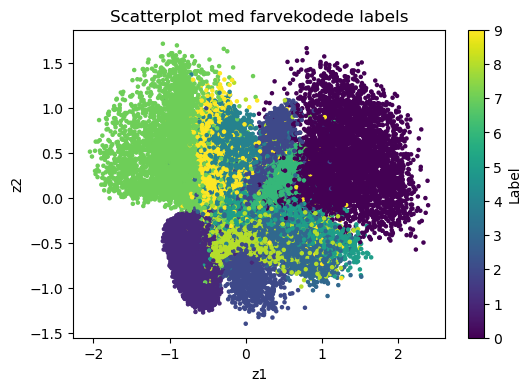

In [60]:
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
#dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
from torch.utils.data import Subset
dataloader = test_loader = DataLoader(
                          test_dataset,
                          batch_size=1,
                          shuffle=False,
                      )



listt = []

for x0, label in dataloader:
    x0 = x0.view(x0.size(0), -1)
    with torch.no_grad():
        output, _ , x = emodel(x0)
        #torch.cat((xt, emodel(x0)), dim=1)
        listt.append((output, label))

coords = [t[0].squeeze() for t in listt]  # Hver er nu en tensor med form [2]
labels = [t[1].item() for t in listt]       # Konverter label til et tal

# Udtræk x- og y-værdier:
xs = [pt[0].item() for pt in coords]
ys = [pt[1].item() for pt in coords]

# Lav scatterplot med farve baseret på labels:
plt.figure(figsize=(6,4))
plt.scatter(xs, ys, c=labels, s=5)
plt.colorbar(label='Label')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Scatterplot med farvekodede labels')
plt.show()

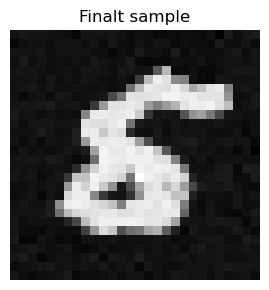

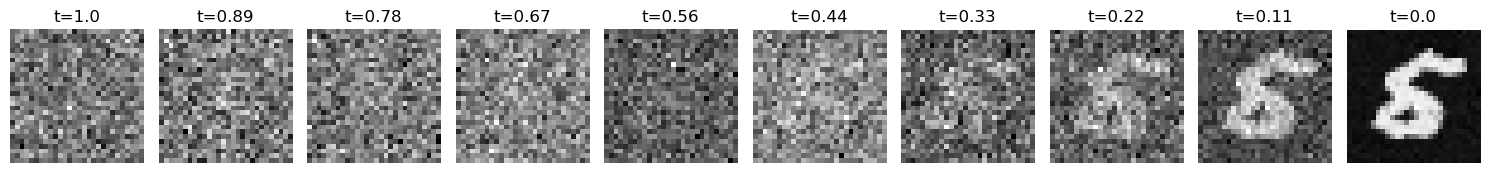

In [69]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)



def sigma(t, smin = 0.01, smax= 50):
    #return t
    return smin * (smax/smin)**t


def betat(t, bmax=20, bmin=0.1):
    return bmin + t * (bmax - bmin)

def backward(xt, t, z, delta=0.1, type = "VP"):
    with torch.no_grad():

        t_time = torch.full((xt.size(0), 1), t, dtype=torch.float32)
        noise = torch.randn_like(xt)
        wiener = noise * np.sqrt(delta)

        z, _, _ = emodel(z)

        if type == "VP":

          xtd = xt + 0.5 * betat(t) * xt * delta \
                + betat(t) * dmodel(xt, t_time, z) * delta \
                + np.sqrt(betat(t)) * wiener

        elif type == "VE":

          smin, smax = 0.01, 50

          torch.tensor(sigma(t)**2 - sigma(0)**2, dtype=torch.float32)

          g = sigma(t) * math.sqrt(2*math.log(smax/smin))
          xtd = (
              xt
              - g**2 * dmodel(xt, t_time, z) * delta
              + g * noise * math.sqrt(delta)
          )



    return xtd



def forward_process(x0, t, bmax=20, bmin=0.1, type = "VP"):

    if type == "VE":

        var = torch.tensor(sigma(t)**2 - sigma(0)**2, dtype=torch.float32)
        noise = torch.randn_like(x0)
        std = torch.sqrt(var)
        xt = x0   +  std  * noise
        logp = -noise / std


    elif type == "VP":
        var = torch.tensor(1 - np.exp(-0.5 * t**2 * (bmax - bmin) - t * bmin),
                      dtype=torch.float32, device=x0.device)
        noise = torch.randn_like(x0)
        std = torch.sqrt(var)
        mu = torch.tensor(np.exp(-0.25 * t**2 * (bmax - bmin) - 0.5 * t * bmin),
                          dtype=torch.float32, device=x0.device) * x0
        xt = mu + std * noise
        logp = -noise / std

    return xt, logp




indices = (dataset.targets == 1).nonzero(as_tuple=True)[0].tolist()
x0, _ = dataset[random.choice(indices)]
x0 = x0.view(1, -1)



x0 = torch.randn_like(x0)

# Start forward process (t=1)
xt, _ = forward_process(x0, 1, type = "VP")


# Definer delta (tidssteg)
delta = 0.001
t_values = np.arange(1, -delta, -delta)

x = 6
z = dataset[random.choice((dataset.targets == x).nonzero(as_tuple=True)[0].tolist())][0]
z = z.view(z.size(0), -1)



# Gem samples under backward process
samples = [xt.clone()]
for t in t_values[1:]:
    xt = backward(xt, t, z, delta=delta, type = "VP")
    samples.append(xt.clone())

# Plot det endelige sample (sidste billede)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
img_to_show = samples[-1].view(28, 28).cpu().numpy()
ax.imshow(img_to_show, cmap='gray')
ax.set_title("Finalt sample")
ax.axis("off")
plt.tight_layout()
plt.show()

# Plot en række billeder jævnt fordelt over processen (fx 10 billeder)
n_to_plot = 10
indices_to_plot = np.linspace(0, len(samples) - 1, n_to_plot, dtype=int)
fig, axes = plt.subplots(1, n_to_plot, figsize=(15, 2))
for i, idx in enumerate(indices_to_plot):
    img = samples[idx]
    img_to_show = img.view(28, 28).cpu().numpy()
    axes[i].imshow(img_to_show, cmap='gray')
    t_val = 1 - idx * delta
    axes[i].set_title(f"t={round(t_val, 2)}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()


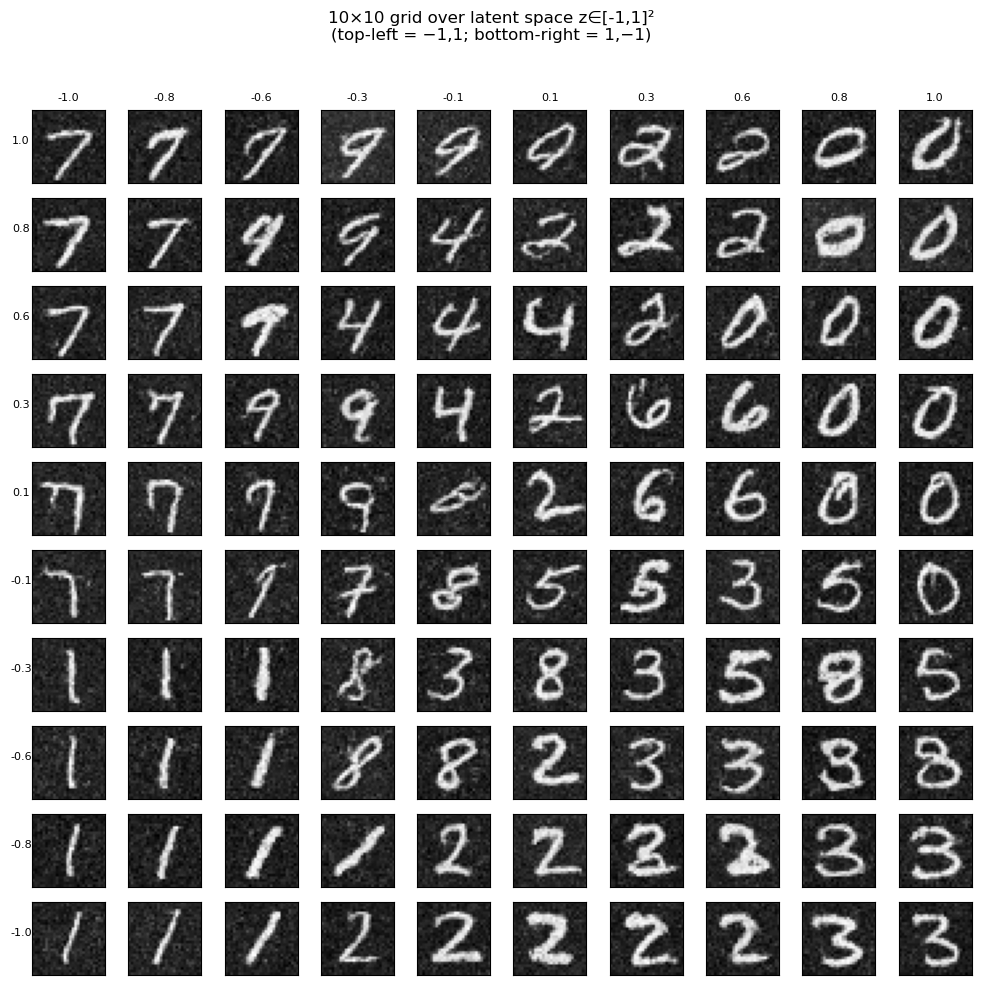

In [62]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def betat(t, bmax=20, bmin=0.1):
    return bmin + t * (bmax - bmin)

def backward(xt, t, z, delta=0.1, type="VP"):
    with torch.no_grad():
        device = xt.device
        t_time = torch.full((xt.size(0), 1), t,
                            dtype=torch.float32, device=device)
        noise  = torch.randn_like(xt)
        wiener = noise * math.sqrt(delta)

        # Fjern denne linje – z er allerede latent_mu fra emodel(x0)
        # z, _, _ = emodel(z)

        if type == "VP":
            beta_t = betat(t)
            xtd = (
                xt
                - 0.5 * beta_t * xt * delta
                + beta_t * dmodel(xt, t_time, z) * delta
                + math.sqrt(beta_t) * wiener
            )

        elif type == "VE":
            smin, smax = 0.01, 50
            sigma_t = sigma(t, smin, smax)
            g       = sigma_t * math.sqrt(2 * math.log(smax/smin))

            xtd = (
                xt
                - g**2 * dmodel(xt, t_time, z) * delta
                + g   * noise * math.sqrt(delta)
            )

        else:
            raise ValueError(f"Unknown SDE type {type!r}")

    return xtd

def betat(t, bmax=20, bmin=0.1):
    return bmin + t * (bmax - bmin)

# 1) Lav et 10×10 grid over latent space [-2,2]×[-2,2]
grid_size = 10
zs = []
xs = np.linspace(-1.0, 1.0, grid_size)      # latent x-koordinater
ys = np.linspace( 1.0, -1.0, grid_size)     # latent y-koordinater (omvendt for plotting)
for yi in ys:
    row = []
    for xi in xs:
        z = torch.tensor([[xi, yi]], dtype=torch.float32, device=device)  # shape (1,2)
        row.append(z)
    zs.append(row)

# 2) Generér én sample per grid-celle via diffusion
n_steps    = 50
delta      = 1.0 / n_steps
t_schedule = np.linspace(1.0, 0.0, n_steps+1)

samples = [[None]*grid_size for _ in range(grid_size)]
with torch.no_grad():
    for i in range(grid_size):
        for j in range(grid_size):
            z = zs[i][j]
            # start fra rent støj
            noise = torch.randn(1, 28*28, device=device)
            xt, _ = forward_process(noise, 1.0)
            # kør backward-process
            for t in t_schedule[1:]:
                xt = backward(xt, t, z, delta)
            samples[i][j] = xt.view(28,28).cpu().numpy()

# 3) Plot 10×10 grid
fig, axs = plt.subplots(grid_size, grid_size, figsize=(10,10),
                        subplot_kw={'xticks':[], 'yticks':[]})
for i in range(grid_size):
    for j in range(grid_size):
        axs[i,j].imshow(samples[i][j], cmap='gray')
        if i==0:  axs[i,j].set_title(f"{xs[j]:.1f}", fontsize=8)
        if j==0:  axs[i,j].set_ylabel(f"{ys[i]:.1f}", rotation=0, labelpad=8, fontsize=8)
plt.suptitle("10×10 grid over latent space z∈[-1,1]²\n(top-left = −1,1; bottom-right = 1,−1)", fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


J_VDRL

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

full_dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
train_size = 1000
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Uniform

In [36]:
# ---------------------------------------------------------------------------
#   Find / indlæs  helpers.py ,  unet.py ,  encoder.py  +  vægtfiler
#   – fungerer både i .py-skript og i Jupyter-notebook
# ---------------------------------------------------------------------------
import torch, importlib.util, pathlib, sys, types

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------- 1) Projektrod --------------------------------------------------
try:
    ROOT = pathlib.Path(__file__).resolve().parent          # når du kører .py
except NameError:
    ROOT = pathlib.Path().resolve()                         # Jupyter-notebook

# ----------- 2) Find filerne ------------------------------------------------
MODEL_DIR  = next((p for p in [ROOT,
                               ROOT / "model",
                               ROOT / "src" / "model"]
                   if (p / "unet.py").exists()), None)
if MODEL_DIR is None:
    raise FileNotFoundError("Kunne ikke finde unet.py / encoder.py i projektet")

HELPERS_PATH = MODEL_DIR / "helpers.py"
UNET_PATH    = MODEL_DIR / "unet.py"
ENC_PATH     = MODEL_DIR / "encoder.py"

# ----------- 3) Opret 'model'-pakke-stub i sys.modules ---------------------
pkg_name = "model"
if pkg_name not in sys.modules:
    pkg = types.ModuleType(pkg_name)
    pkg.__path__ = [str(MODEL_DIR)]       # gør det til en pakkestub
    sys.modules[pkg_name] = pkg

# ----------- 4) Dynamisk import som  model.helpers  ------------------------
def import_as(fullname: str, py_path: pathlib.Path):
    spec = importlib.util.spec_from_file_location(fullname, py_path)
    mod  = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    sys.modules[fullname] = mod
    return mod

helpers_mod = import_as(f"{pkg_name}.helpers", HELPERS_PATH)
unet_mod    = import_as(f"{pkg_name}.unet",     UNET_PATH)
enc_mod     = import_as(f"{pkg_name}.encoder",  ENC_PATH)

DenoisingNN = unet_mod.DenoisingNN
EncoderNN   = enc_mod.EncoderNN

# ----------- 5) Vægtfiler ---------------------------------------------------
WEIGHT_DIR = next((p for p in [ROOT / "loadparameters",
                               ROOT / "src" / "loadparameters"]
                   if (p / "ScoreDifl1betaVP.pt").exists()), None)
if WEIGHT_DIR is None:
    raise FileNotFoundError("Kunne ikke finde vægtfilerne i projektet")

def load_weights(model: torch.nn.Module, fname: str):
    wfile = WEIGHT_DIR / fname
    if not wfile.exists():
        raise FileNotFoundError(f"Mangler vægtfil: {wfile}")
    model.load_state_dict(torch.load(wfile, map_location=device))
    return model.to(device).eval()

dmodel = load_weights(DenoisingNN(), "ScoreDifKLuniformVP.pt")
emodel = load_weights(EncoderNN(),   "ScoreEncKLuniformVP.pt")

print("✔️  Alt indlæst korrekt!")
print(f"   • helpers   : {HELPERS_PATH}")
print(f"   • unet      : {UNET_PATH}")
print(f"   • encoder   : {ENC_PATH}")
print(f"   • vægte fra : {WEIGHT_DIR}")


✔️  Alt indlæst korrekt!
   • helpers   : /Users/muhammadhussain/Desktop/BSc/src/model/helpers.py
   • unet      : /Users/muhammadhussain/Desktop/BSc/src/model/unet.py
   • encoder   : /Users/muhammadhussain/Desktop/BSc/src/model/encoder.py
   • vægte fra : /Users/muhammadhussain/Desktop/BSc/src/loadparameters


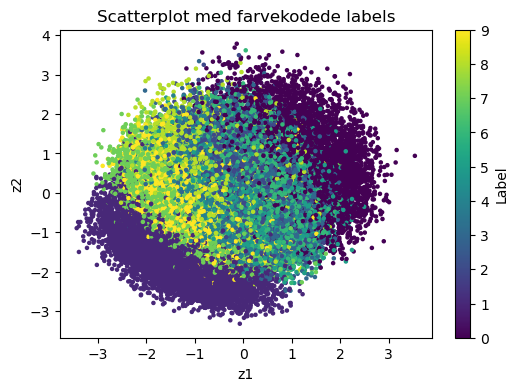

In [38]:
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
#dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
from torch.utils.data import Subset
dataloader = test_loader = DataLoader(
                          test_dataset,
                          batch_size=1,
                          shuffle=False,
                      )



listt = []

for x0, label in dataloader:
    x0 = x0.view(x0.size(0), -1)
    with torch.no_grad():
        _, _ , output = emodel(x0)
        #torch.cat((xt, emodel(x0)), dim=1)
        listt.append((output, label))

coords = [t[0].squeeze() for t in listt]  # Hver er nu en tensor med form [2]
labels = [t[1].item() for t in listt]       # Konverter label til et tal

# Udtræk x- og y-værdier:
xs = [pt[0].item() for pt in coords]
ys = [pt[1].item() for pt in coords]

# Lav scatterplot med farve baseret på labels:
plt.figure(figsize=(6,4))
plt.scatter(xs, ys, c=labels, s=5)
plt.colorbar(label='Label')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Scatterplot med farvekodede labels')
plt.show()

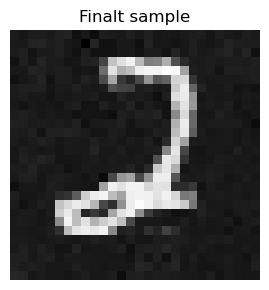

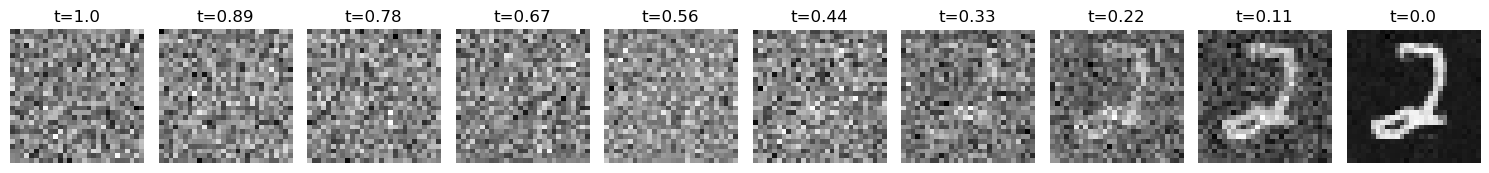

In [39]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)



def sigma(t, smin = 0.01, smax= 50):
    #return t
    return smin * (smax/smin)**t


def betat(t, bmax=20, bmin=0.1):
    return bmin + t * (bmax - bmin)

def backward(xt, t, z, delta=0.1, type = "VP"):
    with torch.no_grad():

        t_time = torch.full((xt.size(0), 1), t, dtype=torch.float32)
        noise = torch.randn_like(xt)
        wiener = noise * np.sqrt(delta)

        _, _, z = emodel(z)

        if type == "VP":

          xtd = xt + 0.5 * betat(t) * xt * delta \
                + betat(t) * dmodel(xt, t_time, z) * delta \
                + np.sqrt(betat(t)) * wiener

        elif type == "VE":

          smin, smax = 0.01, 50

          torch.tensor(sigma(t)**2 - sigma(0)**2, dtype=torch.float32)

          g = sigma(t) * math.sqrt(2*math.log(smax/smin))
          xtd = (
              xt
              - g**2 * dmodel(xt, t_time, z) * delta
              + g * noise * math.sqrt(delta)
          )



    return xtd



def forward_process(x0, t, bmax=20, bmin=0.1, type = "VP"):

    if type == "VE":

        var = torch.tensor(sigma(t)**2 - sigma(0)**2, dtype=torch.float32)
        noise = torch.randn_like(x0)
        std = torch.sqrt(var)
        xt = x0   +  std  * noise
        logp = -noise / std


    elif type == "VP":
        var = torch.tensor(1 - np.exp(-0.5 * t**2 * (bmax - bmin) - t * bmin),
                      dtype=torch.float32, device=x0.device)
        noise = torch.randn_like(x0)
        std = torch.sqrt(var)
        mu = torch.tensor(np.exp(-0.25 * t**2 * (bmax - bmin) - 0.5 * t * bmin),
                          dtype=torch.float32, device=x0.device) * x0
        xt = mu + std * noise
        logp = -noise / std

    return xt, logp




indices = (dataset.targets == 1).nonzero(as_tuple=True)[0].tolist()
x0, _ = dataset[random.choice(indices)]
x0 = x0.view(1, -1)



x0 = torch.randn_like(x0)

# Start forward process (t=1)
xt, _ = forward_process(x0, 1, type = "VP")


# Definer delta (tidssteg)
delta = 0.001
t_values = np.arange(1, -delta, -delta)

x = 6
z = dataset[random.choice((dataset.targets == x).nonzero(as_tuple=True)[0].tolist())][0]
z = z.view(z.size(0), -1)



# Gem samples under backward process
samples = [xt.clone()]
for t in t_values[1:]:
    xt = backward(xt, t, z, delta=delta, type = "VP")
    samples.append(xt.clone())

# Plot det endelige sample (sidste billede)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
img_to_show = samples[-1].view(28, 28).cpu().numpy()
ax.imshow(img_to_show, cmap='gray')
ax.set_title("Finalt sample")
ax.axis("off")
plt.tight_layout()
plt.show()

# Plot en række billeder jævnt fordelt over processen (fx 10 billeder)
n_to_plot = 10
indices_to_plot = np.linspace(0, len(samples) - 1, n_to_plot, dtype=int)
fig, axes = plt.subplots(1, n_to_plot, figsize=(15, 2))
for i, idx in enumerate(indices_to_plot):
    img = samples[idx]
    img_to_show = img.view(28, 28).cpu().numpy()
    axes[i].imshow(img_to_show, cmap='gray')
    t_val = 1 - idx * delta
    axes[i].set_title(f"t={round(t_val, 2)}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()


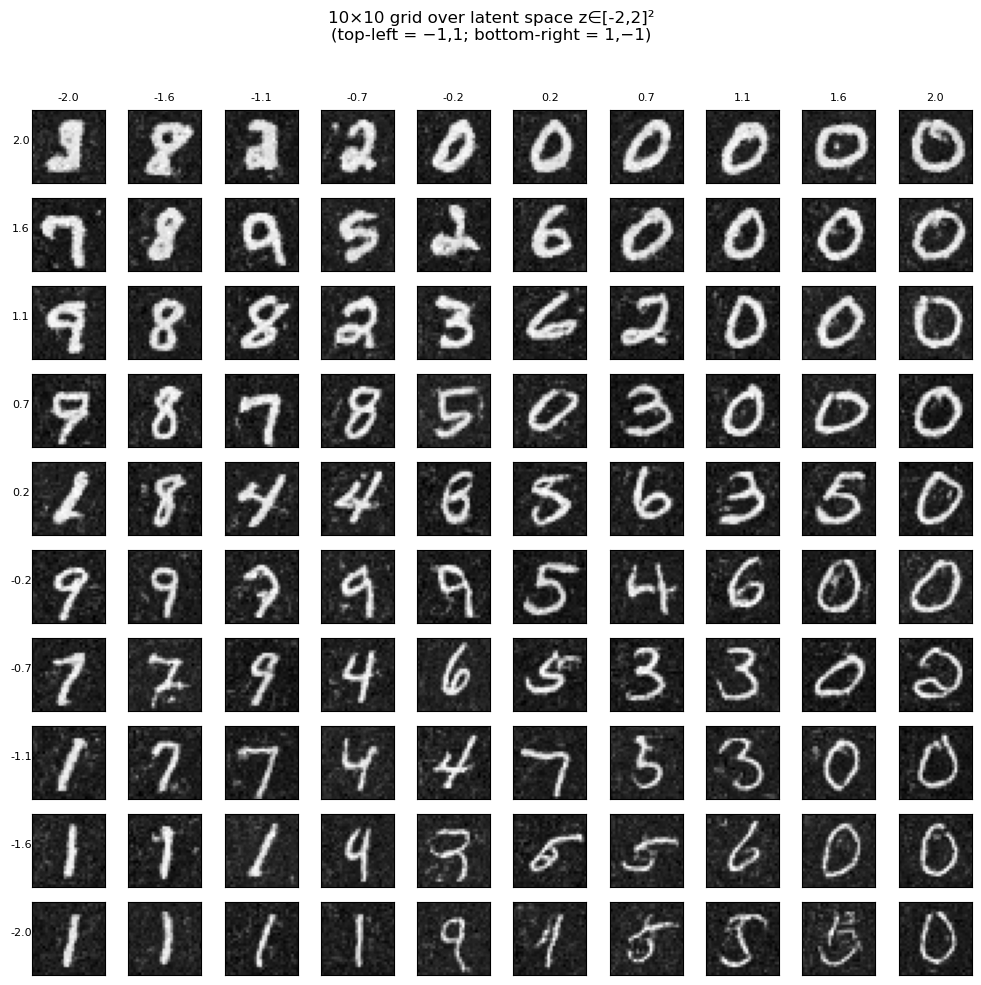

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def betat(t, bmax=20, bmin=0.1):
    return bmin + t * (bmax - bmin)

def backward(xt, t, z, delta=0.1, type="VP"):
    with torch.no_grad():
        device = xt.device
        t_time = torch.full((xt.size(0), 1), t,
                            dtype=torch.float32, device=device)
        noise  = torch.randn_like(xt)
        wiener = noise * math.sqrt(delta)

        # Fjern denne linje – z er allerede latent_mu fra emodel(x0)
        # z, _, _ = emodel(z)

        if type == "VP":
            beta_t = betat(t)
            xtd = (
                xt
                - 0.5 * beta_t * xt * delta
                + beta_t * dmodel(xt, t_time, z) * delta
                + math.sqrt(beta_t) * wiener
            )

        elif type == "VE":
            smin, smax = 0.01, 50
            sigma_t = sigma(t, smin, smax)
            g       = sigma_t * math.sqrt(2 * math.log(smax/smin))

            xtd = (
                xt
                - g**2 * dmodel(xt, t_time, z) * delta
                + g   * noise * math.sqrt(delta)
            )

        else:
            raise ValueError(f"Unknown SDE type {type!r}")

    return xtd

def betat(t, bmax=20, bmin=0.1):
    return bmin + t * (bmax - bmin)

# 1) Lav et 10×10 grid over latent space [-2,2]×[-2,2]
grid_size = 10
zs = []
xs = np.linspace(-2.0, 2.0, grid_size)      # latent x-koordinater
ys = np.linspace( 2.0, -2.0, grid_size)     # latent y-koordinater (omvendt for plotting)
for yi in ys:
    row = []
    for xi in xs:
        z = torch.tensor([[xi, yi]], dtype=torch.float32, device=device)  # shape (1,2)
        row.append(z)
    zs.append(row)

# 2) Generér én sample per grid-celle via diffusion
n_steps    = 50
delta      = 1.0 / n_steps
t_schedule = np.linspace(1.0, 0.0, n_steps+1)

samples = [[None]*grid_size for _ in range(grid_size)]
with torch.no_grad():
    for i in range(grid_size):
        for j in range(grid_size):
            z = zs[i][j]
            # start fra rent støj
            noise = torch.randn(1, 28*28, device=device)
            xt, _ = forward_process(noise, 1.0)
            # kør backward-process
            for t in t_schedule[1:]:
                xt = backward(xt, t, z, delta)
            samples[i][j] = xt.view(28,28).cpu().numpy()

# 3) Plot 10×10 grid
fig, axs = plt.subplots(grid_size, grid_size, figsize=(10,10),
                        subplot_kw={'xticks':[], 'yticks':[]})
for i in range(grid_size):
    for j in range(grid_size):
        axs[i,j].imshow(samples[i][j], cmap='gray')
        if i==0:  axs[i,j].set_title(f"{xs[j]:.1f}", fontsize=8)
        if j==0:  axs[i,j].set_ylabel(f"{ys[i]:.1f}", rotation=0, labelpad=8, fontsize=8)
plt.suptitle("10×10 grid over latent space z∈[-2,2]²\n(top-left = −2,2; bottom-right = 2,−2)", fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


Beta

In [70]:
# ---------------------------------------------------------------------------
#   Find / indlæs  helpers.py ,  unet.py ,  encoder.py  +  vægtfiler
#   – fungerer både i .py-skript og i Jupyter-notebook
# ---------------------------------------------------------------------------
import torch, importlib.util, pathlib, sys, types

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------- 1) Projektrod --------------------------------------------------
try:
    ROOT = pathlib.Path(__file__).resolve().parent          # når du kører .py
except NameError:
    ROOT = pathlib.Path().resolve()                         # Jupyter-notebook

# ----------- 2) Find filerne ------------------------------------------------
MODEL_DIR  = next((p for p in [ROOT,
                               ROOT / "model",
                               ROOT / "src" / "model"]
                   if (p / "unet.py").exists()), None)
if MODEL_DIR is None:
    raise FileNotFoundError("Kunne ikke finde unet.py / encoder.py i projektet")

HELPERS_PATH = MODEL_DIR / "helpers.py"
UNET_PATH    = MODEL_DIR / "unet.py"
ENC_PATH     = MODEL_DIR / "encoder.py"

# ----------- 3) Opret 'model'-pakke-stub i sys.modules ---------------------
pkg_name = "model"
if pkg_name not in sys.modules:
    pkg = types.ModuleType(pkg_name)
    pkg.__path__ = [str(MODEL_DIR)]       # gør det til en pakkestub
    sys.modules[pkg_name] = pkg

# ----------- 4) Dynamisk import som  model.helpers  ------------------------
def import_as(fullname: str, py_path: pathlib.Path):
    spec = importlib.util.spec_from_file_location(fullname, py_path)
    mod  = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    sys.modules[fullname] = mod
    return mod

helpers_mod = import_as(f"{pkg_name}.helpers", HELPERS_PATH)
unet_mod    = import_as(f"{pkg_name}.unet",     UNET_PATH)
enc_mod     = import_as(f"{pkg_name}.encoder",  ENC_PATH)

DenoisingNN = unet_mod.DenoisingNN
EncoderNN   = enc_mod.EncoderNN

# ----------- 5) Vægtfiler ---------------------------------------------------
WEIGHT_DIR = next((p for p in [ROOT / "loadparameters",
                               ROOT / "src" / "loadparameters"]
                   if (p / "ScoreDifl1betaVP.pt").exists()), None)
if WEIGHT_DIR is None:
    raise FileNotFoundError("Kunne ikke finde vægtfilerne i projektet")

def load_weights(model: torch.nn.Module, fname: str):
    wfile = WEIGHT_DIR / fname
    if not wfile.exists():
        raise FileNotFoundError(f"Mangler vægtfil: {wfile}")
    model.load_state_dict(torch.load(wfile, map_location=device))
    return model.to(device).eval()

dmodel = load_weights(DenoisingNN(), "ScoreDifKLBetaVP.pt")
emodel = load_weights(EncoderNN(),   "ScoreEncKLBetaVP.pt")

print("✔️  Alt indlæst korrekt!")
print(f"   • helpers   : {HELPERS_PATH}")
print(f"   • unet      : {UNET_PATH}")
print(f"   • encoder   : {ENC_PATH}")
print(f"   • vægte fra : {WEIGHT_DIR}")


✔️  Alt indlæst korrekt!
   • helpers   : /Users/muhammadhussain/Desktop/BSc/src/model/helpers.py
   • unet      : /Users/muhammadhussain/Desktop/BSc/src/model/unet.py
   • encoder   : /Users/muhammadhussain/Desktop/BSc/src/model/encoder.py
   • vægte fra : /Users/muhammadhussain/Desktop/BSc/src/loadparameters


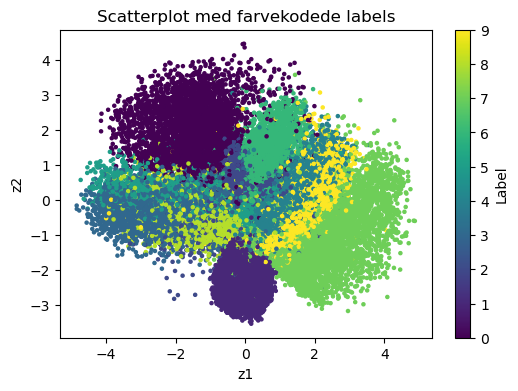

In [71]:
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
#dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
from torch.utils.data import Subset
dataloader = test_loader = DataLoader(
                          test_dataset,
                          batch_size=1,
                          shuffle=False,
                      )



listt = []

for x0, label in dataloader:
    x0 = x0.view(x0.size(0), -1)
    with torch.no_grad():
        _, _ , output = emodel(x0)
        #torch.cat((xt, emodel(x0)), dim=1)
        listt.append((output, label))

coords = [t[0].squeeze() for t in listt]  # Hver er nu en tensor med form [2]
labels = [t[1].item() for t in listt]       # Konverter label til et tal

# Udtræk x- og y-værdier:
xs = [pt[0].item() for pt in coords]
ys = [pt[1].item() for pt in coords]

# Lav scatterplot med farve baseret på labels:
plt.figure(figsize=(6,4))
plt.scatter(xs, ys, c=labels, s=5)
plt.colorbar(label='Label')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Scatterplot med farvekodede labels')
plt.show()

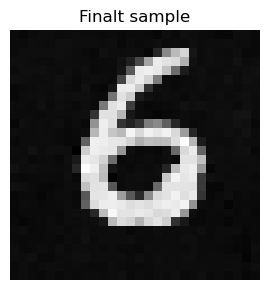

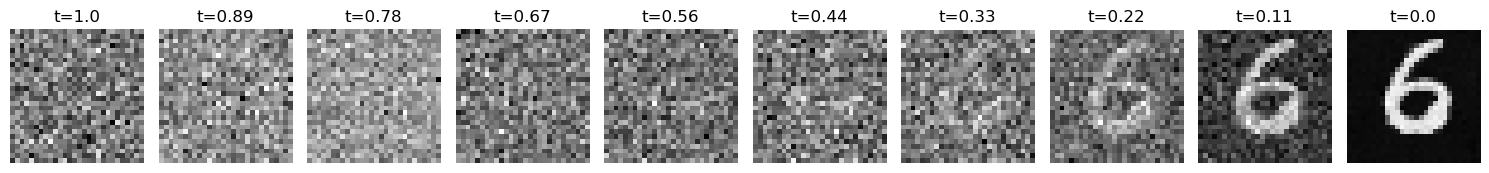

In [77]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)



def sigma(t, smin = 0.01, smax= 50):
    #return t
    return smin * (smax/smin)**t


def betat(t, bmax=20, bmin=0.1):
    return bmin + t * (bmax - bmin)

def backward(xt, t, z, delta=0.1, type = "VP"):
    with torch.no_grad():

        t_time = torch.full((xt.size(0), 1), t, dtype=torch.float32)
        noise = torch.randn_like(xt)
        wiener = noise * np.sqrt(delta)

        _, _, z = emodel(z)

        if type == "VP":

          xtd = xt + 0.5 * betat(t) * xt * delta \
                + betat(t) * dmodel(xt, t_time, z) * delta \
                + np.sqrt(betat(t)) * wiener

        elif type == "VE":

          smin, smax = 0.01, 50

          torch.tensor(sigma(t)**2 - sigma(0)**2, dtype=torch.float32)

          g = sigma(t) * math.sqrt(2*math.log(smax/smin))
          xtd = (
              xt
              - g**2 * dmodel(xt, t_time, z) * delta
              + g * noise * math.sqrt(delta)
          )



    return xtd



def forward_process(x0, t, bmax=20, bmin=0.1, type = "VP"):

    if type == "VE":

        var = torch.tensor(sigma(t)**2 - sigma(0)**2, dtype=torch.float32)
        noise = torch.randn_like(x0)
        std = torch.sqrt(var)
        xt = x0   +  std  * noise
        logp = -noise / std


    elif type == "VP":
        var = torch.tensor(1 - np.exp(-0.5 * t**2 * (bmax - bmin) - t * bmin),
                      dtype=torch.float32, device=x0.device)
        noise = torch.randn_like(x0)
        std = torch.sqrt(var)
        mu = torch.tensor(np.exp(-0.25 * t**2 * (bmax - bmin) - 0.5 * t * bmin),
                          dtype=torch.float32, device=x0.device) * x0
        xt = mu + std * noise
        logp = -noise / std

    return xt, logp




indices = (dataset.targets == 1).nonzero(as_tuple=True)[0].tolist()
x0, _ = dataset[random.choice(indices)]
x0 = x0.view(1, -1)



x0 = torch.randn_like(x0)

# Start forward process (t=1)
xt, _ = forward_process(x0, 1, type = "VP")


# Definer delta (tidssteg)
delta = 0.001
t_values = np.arange(1, -delta, -delta)

x = 6
z = dataset[random.choice((dataset.targets == x).nonzero(as_tuple=True)[0].tolist())][0]
z = z.view(z.size(0), -1)



# Gem samples under backward process
samples = [xt.clone()]
for t in t_values[1:]:
    xt = backward(xt, t, z, delta=delta, type = "VP")
    samples.append(xt.clone())

# Plot det endelige sample (sidste billede)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
img_to_show = samples[-1].view(28, 28).cpu().numpy()
ax.imshow(img_to_show, cmap='gray')
ax.set_title("Finalt sample")
ax.axis("off")
plt.tight_layout()
plt.show()

# Plot en række billeder jævnt fordelt over processen (fx 10 billeder)
n_to_plot = 10
indices_to_plot = np.linspace(0, len(samples) - 1, n_to_plot, dtype=int)
fig, axes = plt.subplots(1, n_to_plot, figsize=(15, 2))
for i, idx in enumerate(indices_to_plot):
    img = samples[idx]
    img_to_show = img.view(28, 28).cpu().numpy()
    axes[i].imshow(img_to_show, cmap='gray')
    t_val = 1 - idx * delta
    axes[i].set_title(f"t={round(t_val, 2)}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()


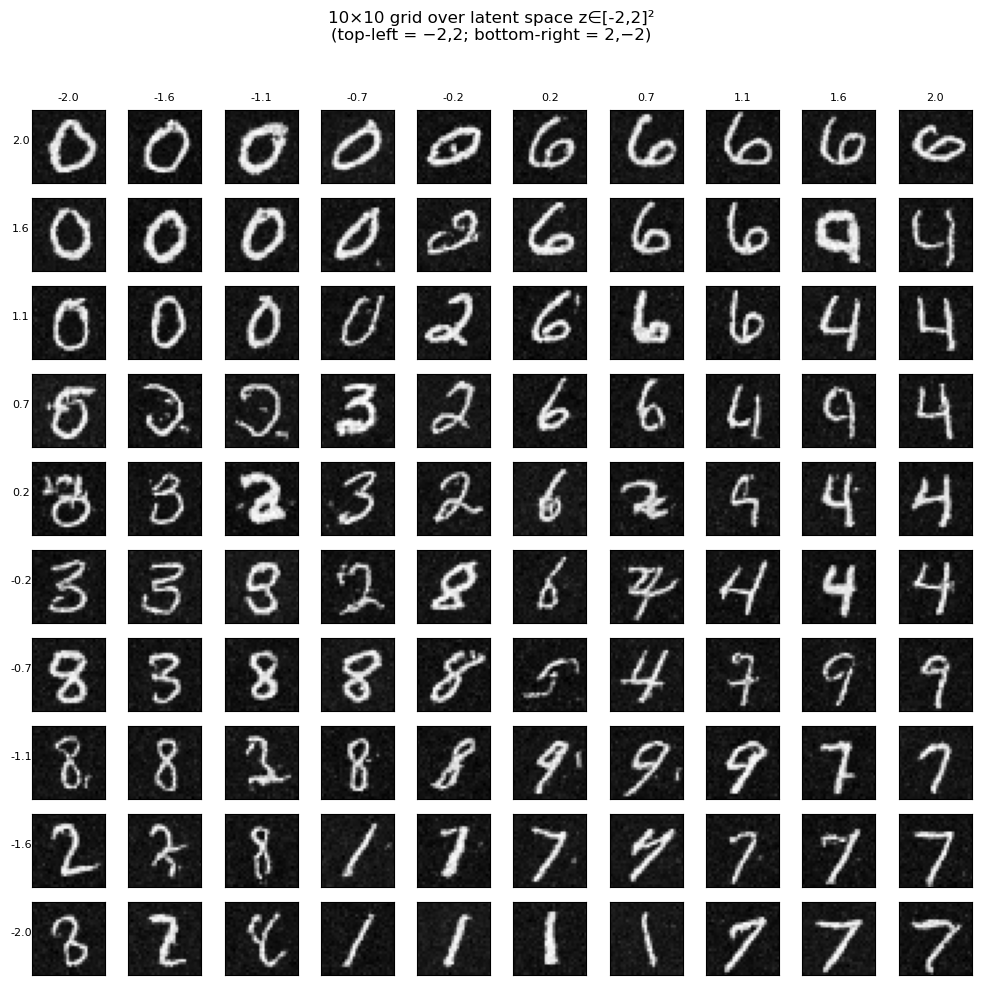

In [73]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def betat(t, bmax=20, bmin=0.1):
    return bmin + t * (bmax - bmin)

def backward(xt, t, z, delta=0.1, type="VP"):
    with torch.no_grad():
        device = xt.device
        t_time = torch.full((xt.size(0), 1), t,
                            dtype=torch.float32, device=device)
        noise  = torch.randn_like(xt)
        wiener = noise * math.sqrt(delta)

        # Fjern denne linje – z er allerede latent_mu fra emodel(x0)
        # z, _, _ = emodel(z)

        if type == "VP":
            beta_t = betat(t)
            xtd = (
                xt
                - 0.5 * beta_t * xt * delta
                + beta_t * dmodel(xt, t_time, z) * delta
                + math.sqrt(beta_t) * wiener
            )

        elif type == "VE":
            smin, smax = 0.01, 50
            sigma_t = sigma(t, smin, smax)
            g       = sigma_t * math.sqrt(2 * math.log(smax/smin))

            xtd = (
                xt
                - g**2 * dmodel(xt, t_time, z) * delta
                + g   * noise * math.sqrt(delta)
            )

        else:
            raise ValueError(f"Unknown SDE type {type!r}")

    return xtd

def betat(t, bmax=20, bmin=0.1):
    return bmin + t * (bmax - bmin)

# 1) Lav et 10×10 grid over latent space [-2,2]×[-2,2]
grid_size = 10
zs = []
xs = np.linspace(-2.0, 2.0, grid_size)      # latent x-koordinater
ys = np.linspace( 2.0, -2.0, grid_size)     # latent y-koordinater (omvendt for plotting)
for yi in ys:
    row = []
    for xi in xs:
        z = torch.tensor([[xi, yi]], dtype=torch.float32, device=device)  # shape (1,2)
        row.append(z)
    zs.append(row)

# 2) Generér én sample per grid-celle via diffusion
n_steps    = 50
delta      = 1.0 / n_steps
t_schedule = np.linspace(1.0, 0.0, n_steps+1)

samples = [[None]*grid_size for _ in range(grid_size)]
with torch.no_grad():
    for i in range(grid_size):
        for j in range(grid_size):
            z = zs[i][j]
            # start fra rent støj
            noise = torch.randn(1, 28*28, device=device)
            xt, _ = forward_process(noise, 1.0)
            # kør backward-process
            for t in t_schedule[1:]:
                xt = backward(xt, t, z, delta)
            samples[i][j] = xt.view(28,28).cpu().numpy()

# 3) Plot 10×10 grid
fig, axs = plt.subplots(grid_size, grid_size, figsize=(10,10),
                        subplot_kw={'xticks':[], 'yticks':[]})
for i in range(grid_size):
    for j in range(grid_size):
        axs[i,j].imshow(samples[i][j], cmap='gray')
        if i==0:  axs[i,j].set_title(f"{xs[j]:.1f}", fontsize=8)
        if j==0:  axs[i,j].set_ylabel(f"{ys[i]:.1f}", rotation=0, labelpad=8, fontsize=8)
plt.suptitle("10×10 grid over latent space z∈[-2,2]²\n(top-left = −2,2; bottom-right = 2,−2)", fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


Our Objective J_GMVDRL

## 3.2 Joint Gaussian-Mixture Diffusion Representation Learning (JGMVDRL)

The JGMVDRL objective augments standard score-based learning with a learnable Gaussian mixture prior over the latent code. Formally, we minimize

$$
\mathcal{J}_{\mathrm{GMVDRL}}
=
\mathbb{E}_{t,\,x_0,\,x_t}
\Bigl[
\underbrace{\lambda(t)\,\bigl\|s_\theta\bigl(x_t,\,t,\,E_\phi(x_0)\bigr)\;-\;\nabla_{x_t}\log p_{0\to t}(x_t\mid x_0)\bigr\|_2^2}_{\text{score‐matching loss}}
\;+\;
\underbrace{\mathrm{KL}\bigl(q_\phi(z\mid x_0)\;\|\;p_{\mathrm{GMM}}(z)\bigr)}_{\text{GMM prior regularization}}
\Bigr].
$$

- **Score-matching loss**  
  Encourages the network \(s_\theta\) to match the true score of the forward SDE at time \(t\).  
  The weighting function  
  $$
    \lambda(t)
    =
    1 \;-\; \exp\!\Bigl(-\tfrac12\,t^2\,(\beta_{\max}-\beta_{\min}) \;-\;\beta_{\min}\,t\Bigr)
  $$
  implements a variance-preserving noise schedule.

- **GMM prior regularization**  
  Aligns the encoder posterior $q_\phi(z\mid x_0)$ with a learnable mixture of Gaussians  
  structuring the latent space into \(K\) clusters.

This combined objective yields representations that both respect the diffusion dynamics (via score matching) and exhibit interpretable cluster structure (via the GMM prior).


Uniform

In [1]:
# ------------------------------------------------------------
#  CELLE 1  –  find unet / encoder / MoG og indlæs vægte
# ------------------------------------------------------------
import importlib.util, types, pathlib, sys, torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 1) Find mapper --------------------------------------------------
ROOT = pathlib.Path().resolve()

def find_model_dir(root):
    for p in [root, root/"model", root/"src"/"model"]:
        if (p/"unet.py").exists() and (p/"encoder.py").exists():
            return p
    raise FileNotFoundError("unet.py + encoder.py ikke fundet")
MODEL_DIR = find_model_dir(ROOT)

def find_weight_dir(root):
    for p in [root/"loadparameters", root/"src"/"loadparameters", root]:
        if p.exists() and list(p.glob("*.pt")):
            return p
    raise FileNotFoundError("Kunne ikke finde mappe med vægtfiler (.pt)")
WEIGHT_DIR = find_weight_dir(ROOT)

# ---------- 2) Stub ‘model’ pakke ------------------------------------------
pkg = types.ModuleType("model"); pkg.__path__ = [str(MODEL_DIR)]
sys.modules["model"] = pkg

def dyn_import(mod_name, py_path):
    spec = importlib.util.spec_from_file_location(mod_name, py_path)
    mod  = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    sys.modules[mod_name] = mod
    return mod

helpers   = dyn_import("model.helpers",  MODEL_DIR/"helpers.py")
unet_mod  = dyn_import("model.unet",     MODEL_DIR/"unet.py")
enc_mod   = dyn_import("model.encoder",  MODEL_DIR/"encoder.py")

# evt. gmvae.py / mog.py
extra_mogs = []
for maybe in ["gmvae.py", "mog.py"]:
    p = MODEL_DIR / maybe
    if p.exists():
        extra_mogs.append(dyn_import(f"model.{maybe[:-3]}", p))

# ---------- 3) Find MoG‐klassen --------------------------------------------
MoG = None
for mod in [helpers, enc_mod, unet_mod, *extra_mogs]:
    if hasattr(mod, "MoG") and callable(mod.MoG):
        MoG = mod.MoG
        break
if MoG is None:
    raise AttributeError("Ingen klasse 'MoG' fundet i dine model-filer")

# ---------- 4) Klasseref’er -------------------------------------------------
DenoisingNN = unet_mod.DenoisingNN
EncoderNN   = enc_mod.EncoderNN

# ---------- 5) Filnavne på vægte  (tilpas hvis anderledes) ------------------

ENC_W = "Egmvdrluniform.pt"
DEN_W = "Dgmvdrluniform.pt"
MOG_W = "Mgmvdrluniform.pt"

# ---------- 6) Loader med *args/**kwargs ------------------------------------
def load(model_cls, wname, *args, **kwargs):
    wfile = WEIGHT_DIR / wname
    if not wfile.exists():
        raise FileNotFoundError(wfile)
    model = model_cls(*args, **kwargs).to(device)
    model.load_state_dict(torch.load(wfile, map_location=device))
    model.eval()
    return model

emodel = load(EncoderNN,  ENC_W)            # ingen ekstra args
dmodel = load(DenoisingNN, DEN_W)           # ingen ekstra args
mog    = load(MoG,        MOG_W, 2, 10)     # <-- D=2, K=10 til MoG

print("✔  Modeller & vægte er indlæst")
print("   • model-dir : ", MODEL_DIR)
print("   • weight-dir: ", WEIGHT_DIR)
print("   • MoG-kilde : ", MoG.__module__)


MoG by JT.
✔  Modeller & vægte er indlæst
   • model-dir :  /Users/muhammadhussain/Desktop/BSc/src/model
   • weight-dir:  /Users/muhammadhussain/Desktop/BSc/src/loadparameters
   • MoG-kilde :  model.gmvae


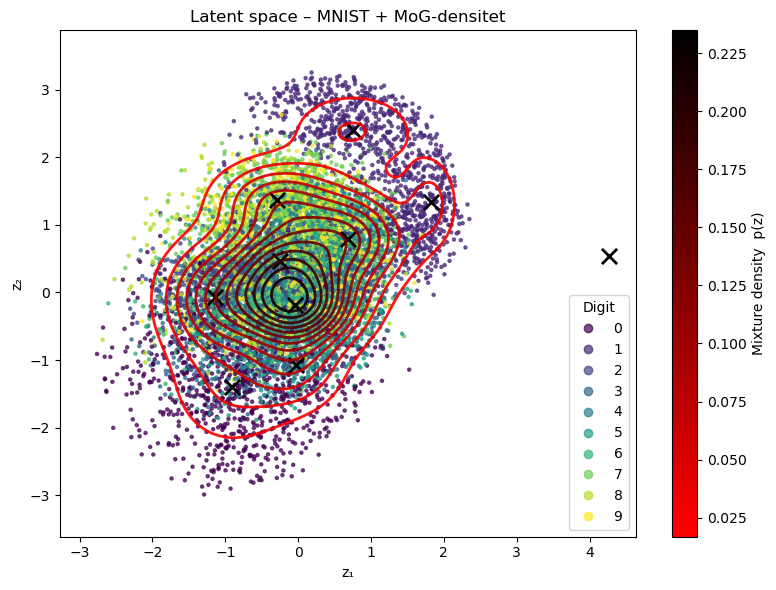

In [2]:
# ------------------------------------------------------------
#  CELLE 2  –  plot latent-space  (bruger emodel & mog)
# ------------------------------------------------------------
import numpy as np, matplotlib.pyplot as plt
from matplotlib import colors
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
full_ds   = datasets.MNIST("data", train=True, download=True, transform=transform)
loader    = DataLoader(Subset(full_ds, range(10_000)), batch_size=1, shuffle=True)

# ---------- 1) hent 10k μ'er + labels --------------------------------------
zs, lbls = [], []
with torch.no_grad():
    for x,y in loader:
        mu,_,_ = emodel(x.view(1,-1).to(device))
        zs.append(mu.cpu())
        lbls.append(y)
zs   = torch.cat(zs).numpy()           # (10000,2)
lbls = torch.cat(lbls).numpy()         # (10000,)

# ---------- 2) MoG-parametre  (DETACH!) ------------------------------------
means   = mog.mu.detach().squeeze(0).cpu().numpy()              # (10,2)
vars_   = torch.exp(mog.log_var.detach().squeeze(0)).cpu().numpy() # (10,2)
weights = F.softmax(mog.w,1).detach().squeeze(0).cpu().numpy()  # (10,)

# ---------- 3) grid + densitet --------------------------------------------
x_min,x_max = zs[:,0].min(), zs[:,0].max()
y_min,y_max = zs[:,1].min(), zs[:,1].max()
dx,dy = x_max-x_min, y_max-y_min
x_min-=.1*dx; x_max+=.1*dx; y_min-=.1*dy; y_max+=.1*dy

nb = 200
X,Y = np.meshgrid(np.linspace(x_min,x_max,nb),
                  np.linspace(y_min,y_max,nb))

def mog_density(xx,yy,mu,var,w):
    pos  = np.stack([xx.ravel(),yy.ravel()],1)
    dens = np.zeros(len(pos))
    for m,v,pi in zip(mu,var,w):
        norm = pi/(2*np.pi*np.sqrt(v[0]*v[1]))
        diff = pos-m
        dens+= norm*np.exp(-0.5*((diff[:,0]**2)/v[0] + (diff[:,1]**2)/v[1]))
    return dens.reshape(xx.shape)

Z = mog_density(X,Y,means,vars_,weights)

# ---------- 4) plot ---------------------------------------------------------
fig,ax = plt.subplots(figsize=(8,6), facecolor="white")
sc = ax.scatter(zs[:,0], zs[:,1], c=lbls, s=5, alpha=.7)
ax.legend(*sc.legend_elements(), title="Digit")

levels = np.linspace(Z.min(), Z.max(), 15)[1:]
cmap   = colors.LinearSegmentedColormap.from_list("red2black", ["red","black"])
norm   = colors.Normalize(vmin=levels.min(), vmax=levels.max())

ax.contour(X,Y,Z, levels=levels,
           colors=[cmap(norm(lv)) for lv in levels],
           linewidths=2, alpha=.9)

ax.scatter(means[:,0], means[:,1], marker="x", s=120, lw=2, c="black")
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)
cbar.set_label("Mixture density  p(z)")

ax.set_title("Latent space – MNIST + MoG-densitet")
ax.set_xlabel("z₁"); ax.set_ylabel("z₂")
plt.tight_layout(); plt.show()


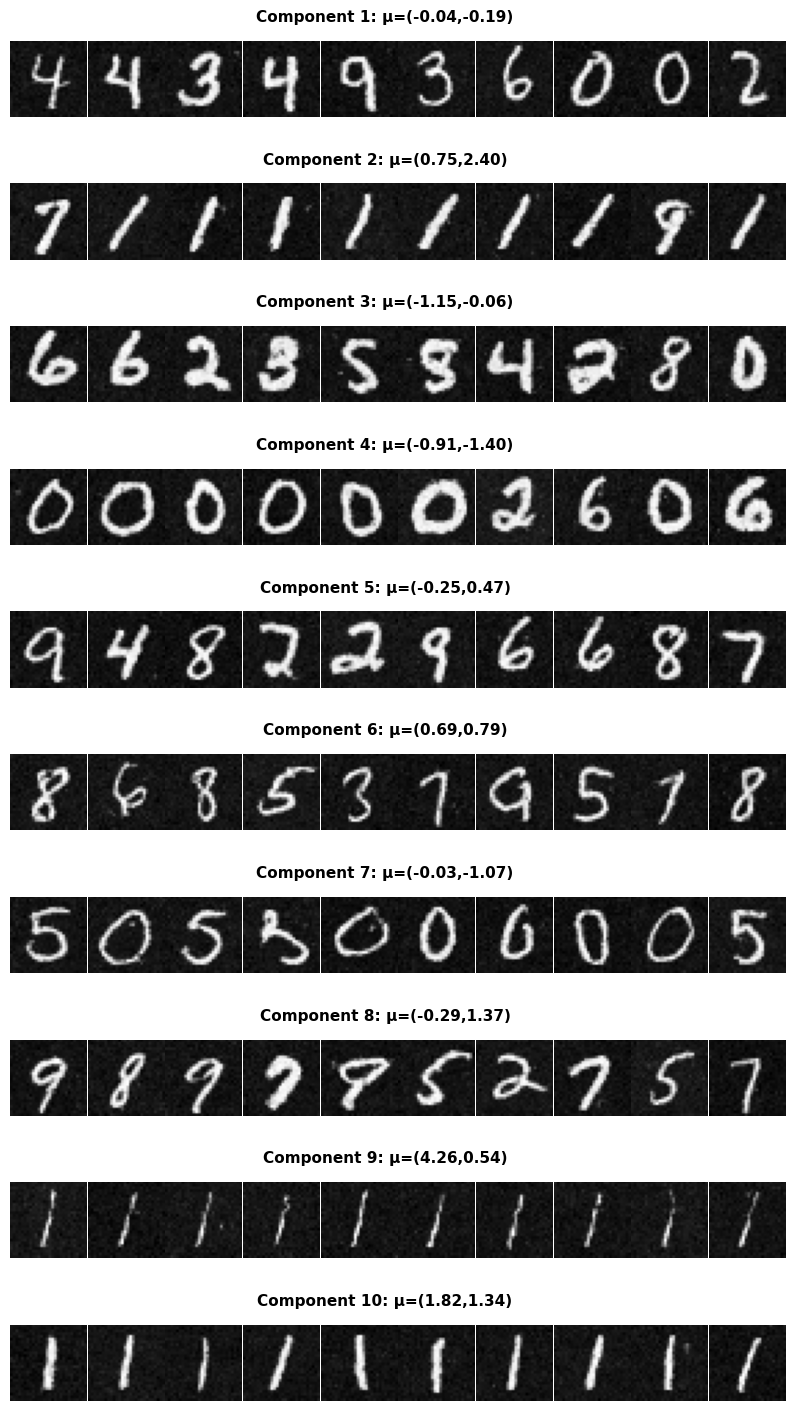

In [80]:
# ------------------------------------------------------------
#  CELLE 3  –  generér 10×10 billeder, én række pr. MoG-komponent
# ------------------------------------------------------------
import math, numpy as np, matplotlib.pyplot as plt
import torch

latent_dim, K   = 2, 10
n_per, n_steps  = 10, 100
delta           = 1.0 / n_steps
t_sched         = np.linspace(1.0, 0.0, n_steps+1)

with torch.no_grad():
    mu_k  = mog.mu.squeeze(0)
    std_k = torch.exp(0.5*mog.log_var.squeeze(0))

def forward_noise(n):
    x0 = torch.randn(n, 28*28, device=device)
    var = 1 - math.exp(-0.5*1*1*19.9 - 0.1*1)
    return x0 * math.sqrt(var) + torch.randn_like(x0)*math.sqrt(var)

@torch.no_grad()
def backward_step(xt, t, z):
    t_time = torch.full((xt.size(0),1), t, device=xt.device)
    beta_t = 0.1 + t*19.9
    noise  = torch.randn_like(xt)*math.sqrt(delta)
    return (xt
            - 0.5*beta_t*xt*delta
            + beta_t*dmodel(xt, t_time, z)*delta
            + math.sqrt(beta_t)*noise)

fig,axes = plt.subplots(K, n_per, figsize=(n_per, K*1.6))
fig.subplots_adjust(top=.92, bottom=.03, wspace=.02, hspace=.02)

for k in range(K):
    z_batch = mu_k[k] + std_k[k]*torch.randn(n_per, latent_dim, device=device)
    xt = forward_noise(n_per)
    for t in t_sched[1:]:
        xt = backward_step(xt, float(t), z_batch)
    imgs = xt.view(-1,28,28).cpu().numpy()

    for j,img in enumerate(imgs):
        ax = axes[k,j]; ax.imshow(img, cmap="gray"); ax.axis("off")

    y = axes[k,0].get_position().y1 + 0.01
    fig.text(0.5, y,
             f"Component {k+1}: μ=({mu_k[k,0]:.2f},{mu_k[k,1]:.2f})",
             ha="center", va="bottom", fontsize=11, fontweight="bold")

plt.show()


Beta

In [81]:
# ------------------------------------------------------------
#  CELLE 1  –  find unet / encoder / MoG og indlæs vægte
# ------------------------------------------------------------
import importlib.util, types, pathlib, sys, torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 1) Find mapper --------------------------------------------------
ROOT = pathlib.Path().resolve()

def find_model_dir(root):
    for p in [root, root/"model", root/"src"/"model"]:
        if (p/"unet.py").exists() and (p/"encoder.py").exists():
            return p
    raise FileNotFoundError("unet.py + encoder.py ikke fundet")
MODEL_DIR = find_model_dir(ROOT)

def find_weight_dir(root):
    for p in [root/"loadparameters", root/"src"/"loadparameters", root]:
        if p.exists() and list(p.glob("*.pt")):
            return p
    raise FileNotFoundError("Kunne ikke finde mappe med vægtfiler (.pt)")
WEIGHT_DIR = find_weight_dir(ROOT)

# ---------- 2) Stub ‘model’ pakke ------------------------------------------
pkg = types.ModuleType("model"); pkg.__path__ = [str(MODEL_DIR)]
sys.modules["model"] = pkg

def dyn_import(mod_name, py_path):
    spec = importlib.util.spec_from_file_location(mod_name, py_path)
    mod  = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    sys.modules[mod_name] = mod
    return mod

helpers   = dyn_import("model.helpers",  MODEL_DIR/"helpers.py")
unet_mod  = dyn_import("model.unet",     MODEL_DIR/"unet.py")
enc_mod   = dyn_import("model.encoder",  MODEL_DIR/"encoder.py")

# evt. gmvae.py / mog.py
extra_mogs = []
for maybe in ["gmvae.py", "mog.py"]:
    p = MODEL_DIR / maybe
    if p.exists():
        extra_mogs.append(dyn_import(f"model.{maybe[:-3]}", p))

# ---------- 3) Find MoG‐klassen --------------------------------------------
MoG = None
for mod in [helpers, enc_mod, unet_mod, *extra_mogs]:
    if hasattr(mod, "MoG") and callable(mod.MoG):
        MoG = mod.MoG
        break
if MoG is None:
    raise AttributeError("Ingen klasse 'MoG' fundet i dine model-filer")

# ---------- 4) Klasseref’er -------------------------------------------------
DenoisingNN = unet_mod.DenoisingNN
EncoderNN   = enc_mod.EncoderNN

# ---------- 5) Filnavne på vægte  (tilpas hvis anderledes) ------------------
ENC_W = "Egmvdrlbeta.pt"
DEN_W = "Dgmvdrlbeta.pt"
MOG_W = "Mgmvdrlbeta.pt"


# ---------- 6) Loader med *args/**kwargs ------------------------------------
def load(model_cls, wname, *args, **kwargs):
    wfile = WEIGHT_DIR / wname
    if not wfile.exists():
        raise FileNotFoundError(wfile)
    model = model_cls(*args, **kwargs).to(device)
    model.load_state_dict(torch.load(wfile, map_location=device))
    model.eval()
    return model

emodel = load(EncoderNN,  ENC_W)            # ingen ekstra args
dmodel = load(DenoisingNN, DEN_W)           # ingen ekstra args
mog    = load(MoG,        MOG_W, 2, 10)     # <-- D=2, K=10 til MoG

print("✔  Modeller & vægte er indlæst")
print("   • model-dir : ", MODEL_DIR)
print("   • weight-dir: ", WEIGHT_DIR)
print("   • MoG-kilde : ", MoG.__module__)


MoG by JT.
✔  Modeller & vægte er indlæst
   • model-dir :  /Users/muhammadhussain/Desktop/BSc/src/model
   • weight-dir:  /Users/muhammadhussain/Desktop/BSc/src/loadparameters
   • MoG-kilde :  model.gmvae


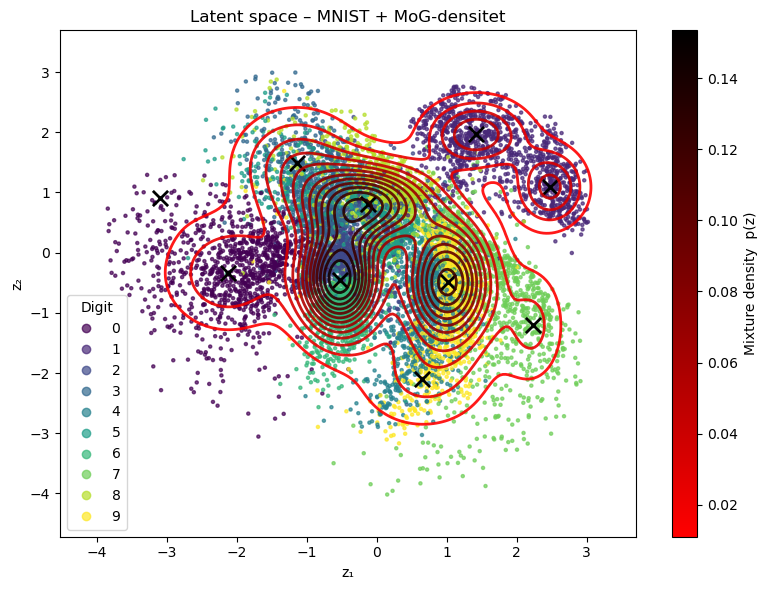

In [84]:
# ------------------------------------------------------------
#  CELLE 2  –  plot latent-space  (bruger emodel & mog)
# ------------------------------------------------------------
import numpy as np, matplotlib.pyplot as plt
from matplotlib import colors
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
full_ds   = datasets.MNIST("data", train=True, download=True, transform=transform)
loader    = DataLoader(Subset(full_ds, range(10_000)), batch_size=1, shuffle=True)

# ---------- 1) hent 10k μ'er + labels --------------------------------------
zs, lbls = [], []
with torch.no_grad():
    for x,y in loader:
        mu,_,_ = emodel(x.view(1,-1).to(device))
        zs.append(mu.cpu())
        lbls.append(y)
zs   = torch.cat(zs).numpy()           # (10000,2)
lbls = torch.cat(lbls).numpy()         # (10000,)

# ---------- 2) MoG-parametre  (DETACH!) ------------------------------------
means   = mog.mu.detach().squeeze(0).cpu().numpy()              # (10,2)
vars_   = torch.exp(mog.log_var.detach().squeeze(0)).cpu().numpy() # (10,2)
weights = F.softmax(mog.w,1).detach().squeeze(0).cpu().numpy()  # (10,)

# ---------- 3) grid + densitet --------------------------------------------
x_min,x_max = zs[:,0].min(), zs[:,0].max()
y_min,y_max = zs[:,1].min(), zs[:,1].max()
dx,dy = x_max-x_min, y_max-y_min
x_min-=.1*dx; x_max+=.1*dx; y_min-=.1*dy; y_max+=.1*dy

nb = 200
X,Y = np.meshgrid(np.linspace(x_min,x_max,nb),
                  np.linspace(y_min,y_max,nb))

def mog_density(xx,yy,mu,var,w):
    pos  = np.stack([xx.ravel(),yy.ravel()],1)
    dens = np.zeros(len(pos))
    for m,v,pi in zip(mu,var,w):
        norm = pi/(2*np.pi*np.sqrt(v[0]*v[1]))
        diff = pos-m
        dens+= norm*np.exp(-0.5*((diff[:,0]**2)/v[0] + (diff[:,1]**2)/v[1]))
    return dens.reshape(xx.shape)

Z = mog_density(X,Y,means,vars_,weights)

# ---------- 4) plot ---------------------------------------------------------
fig,ax = plt.subplots(figsize=(8,6), facecolor="white")
sc = ax.scatter(zs[:,0], zs[:,1], c=lbls, s=5, alpha=.7)
ax.legend(*sc.legend_elements(), title="Digit")

levels = np.linspace(Z.min(), Z.max(), 15)[1:]
cmap   = colors.LinearSegmentedColormap.from_list("red2black", ["red","black"])
norm   = colors.Normalize(vmin=levels.min(), vmax=levels.max())

ax.contour(X,Y,Z, levels=levels,
           colors=[cmap(norm(lv)) for lv in levels],
           linewidths=2, alpha=.9)

ax.scatter(means[:,0], means[:,1], marker="x", s=120, lw=2, c="black")
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)
cbar.set_label("Mixture density  p(z)")

ax.set_title("Latent space – MNIST + MoG-densitet")
ax.set_xlabel("z₁"); ax.set_ylabel("z₂")
plt.tight_layout(); plt.show()


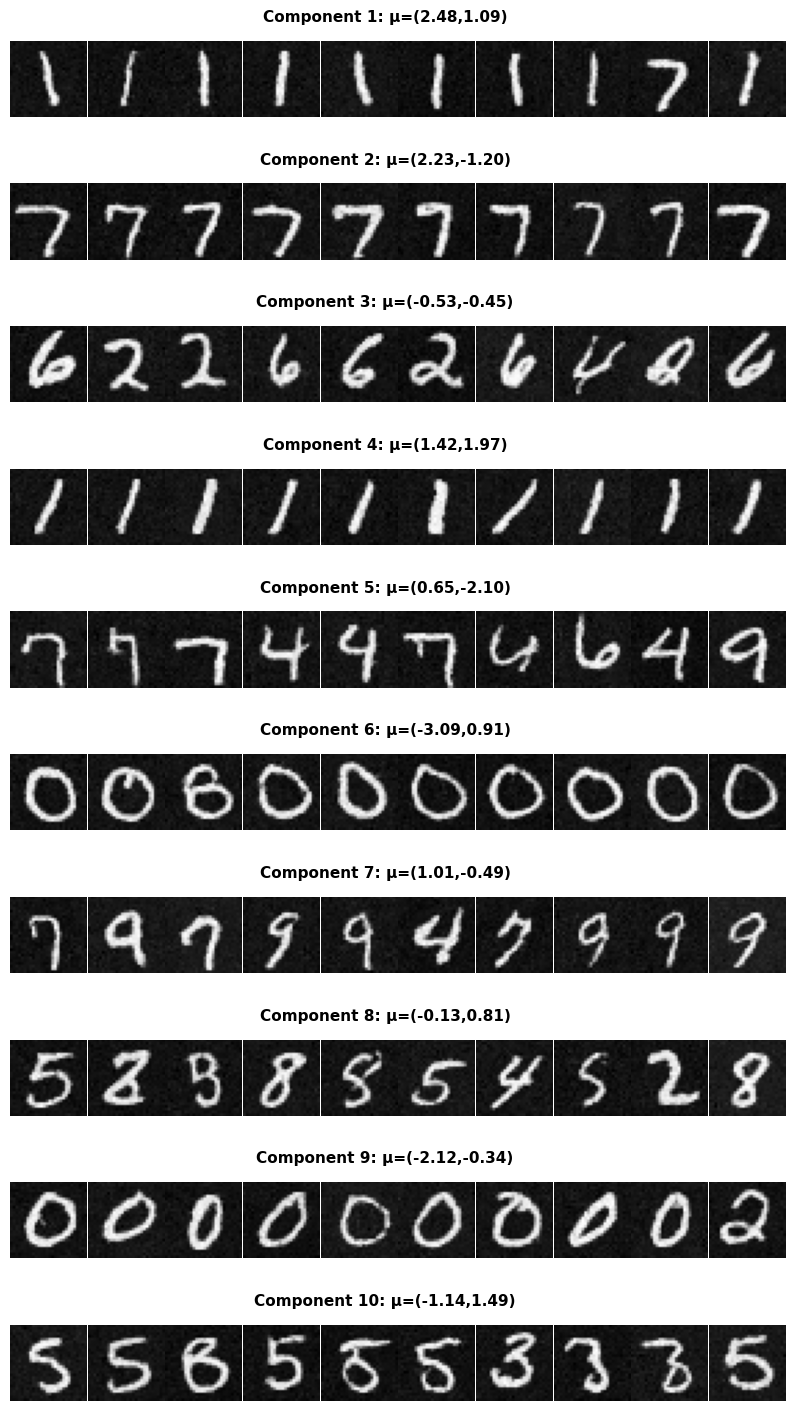

In [83]:
# ------------------------------------------------------------
#  CELLE 3  –  generér 10×10 billeder, én række pr. MoG-komponent
# ------------------------------------------------------------
import math, numpy as np, matplotlib.pyplot as plt
import torch

latent_dim, K   = 2, 10
n_per, n_steps  = 10, 100
delta           = 1.0 / n_steps
t_sched         = np.linspace(1.0, 0.0, n_steps+1)

with torch.no_grad():
    mu_k  = mog.mu.squeeze(0)
    std_k = torch.exp(0.5*mog.log_var.squeeze(0))

def forward_noise(n):
    x0 = torch.randn(n, 28*28, device=device)
    var = 1 - math.exp(-0.5*1*1*19.9 - 0.1*1)
    return x0 * math.sqrt(var) + torch.randn_like(x0)*math.sqrt(var)

@torch.no_grad()
def backward_step(xt, t, z):
    t_time = torch.full((xt.size(0),1), t, device=xt.device)
    beta_t = 0.1 + t*19.9
    noise  = torch.randn_like(xt)*math.sqrt(delta)
    return (xt
            - 0.5*beta_t*xt*delta
            + beta_t*dmodel(xt, t_time, z)*delta
            + math.sqrt(beta_t)*noise)

fig,axes = plt.subplots(K, n_per, figsize=(n_per, K*1.6))
fig.subplots_adjust(top=.92, bottom=.03, wspace=.02, hspace=.02)

for k in range(K):
    z_batch = mu_k[k] + std_k[k]*torch.randn(n_per, latent_dim, device=device)
    xt = forward_noise(n_per)
    for t in t_sched[1:]:
        xt = backward_step(xt, float(t), z_batch)
    imgs = xt.view(-1,28,28).cpu().numpy()

    for j,img in enumerate(imgs):
        ax = axes[k,j]; ax.imshow(img, cmap="gray"); ax.axis("off")

    y = axes[k,0].get_position().y1 + 0.01
    fig.text(0.5, y,
             f"Component {k+1}: μ=({mu_k[k,0]:.2f},{mu_k[k,1]:.2f})",
             ha="center", va="bottom", fontsize=11, fontweight="bold")

plt.show()


## 7  What we learned

* The GM-prior splits the latent space into **well-separated, interpretable clusters** (in some cases).  
* Conditioned sampling reveals **mode-specific styles** (one digit per component), for some of the classes.  
* The diffusion decoder **faithfully inverts** the forward corruption path.

Combined with the quantitative results in the thesis, these plots confirm that  
**Joint Gaussian-Mixture Diffusion Representation Learning** achieves both *good likelihoods* (relatively) and *controllable synthesis* (for some classes).
